In [1]:
import pandas as pd
import numpy as np
import re
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.api import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:
df = pd.read_csv('day.csv')

In [3]:
df.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
#drop instant variable this is just an index and doesn't add to the prediction
df = df.drop(columns=['instant'])

- cast dteday to datetime 

In [7]:
# convert dteday to datetime 
df['dteday'] = pd.to_datetime(df['dteday'],dayfirst=True)

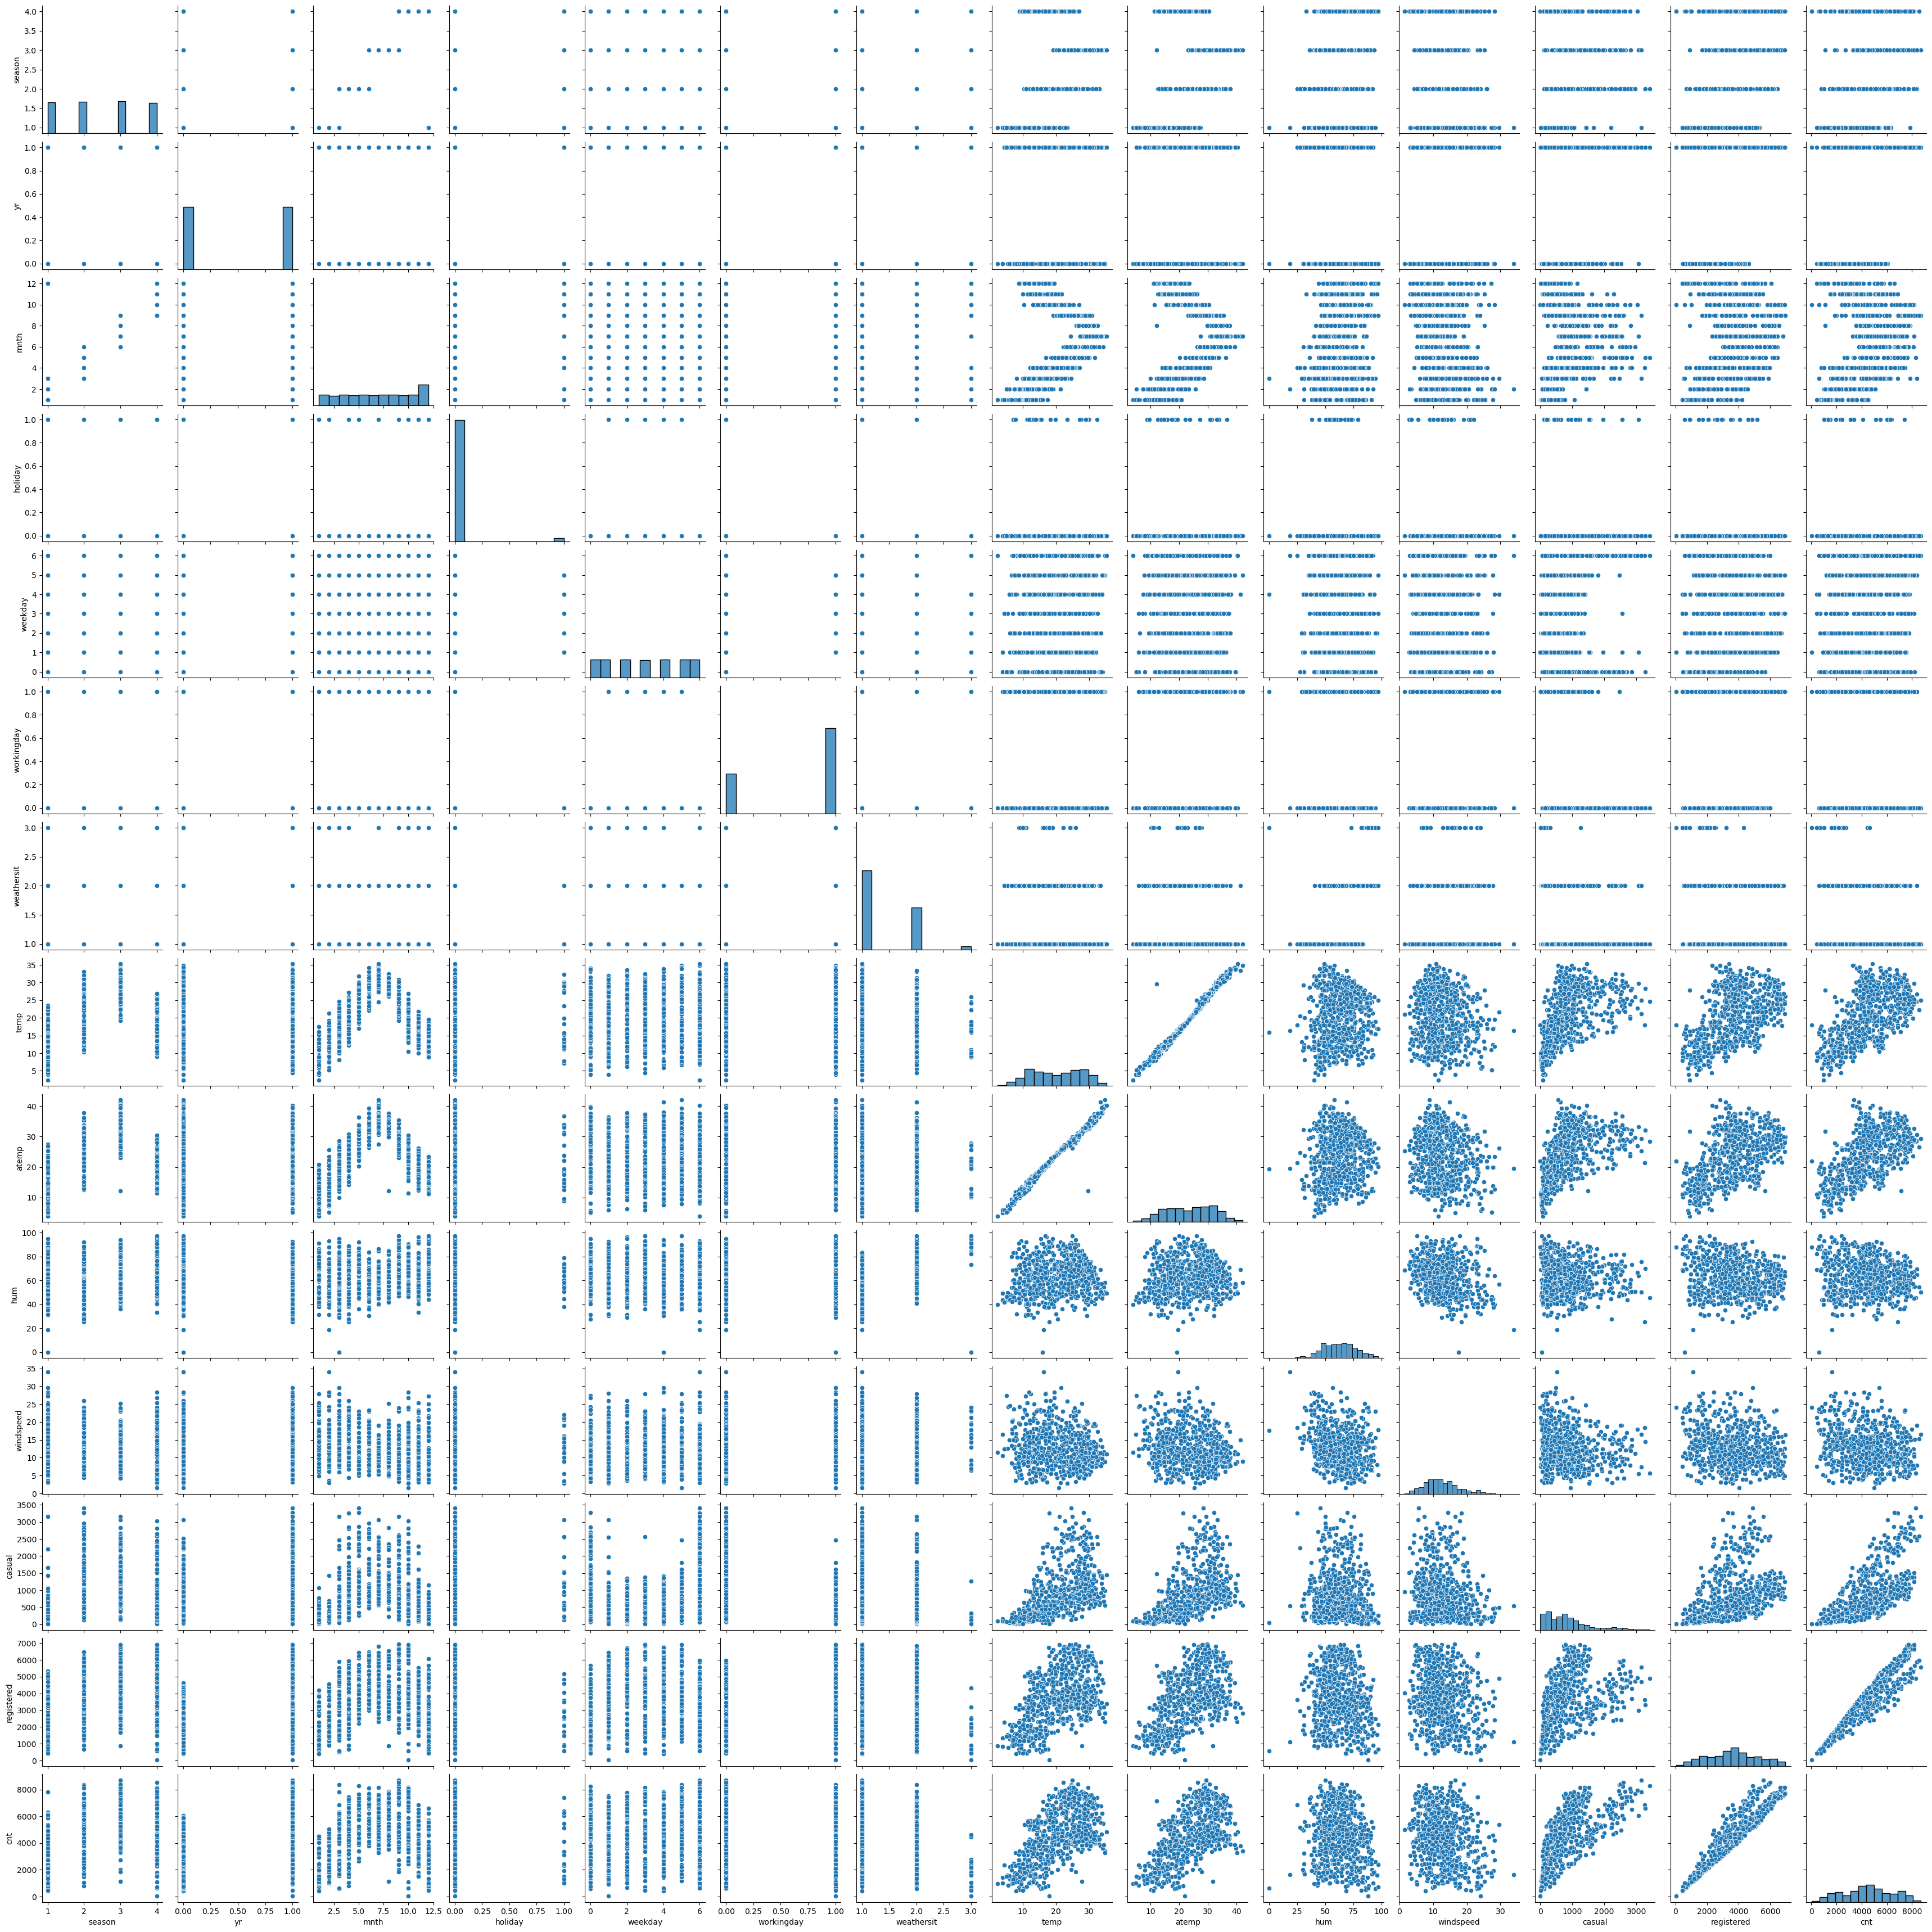

In [8]:
sns.pairplot(df)

In [9]:
df.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

# Outlier Detection

- While taking a glance at the data, there seem to be outliers in windspeed these values don't vary by a large margin , this is mainly because there is not much variance in windspeed , i.e that scale is not large

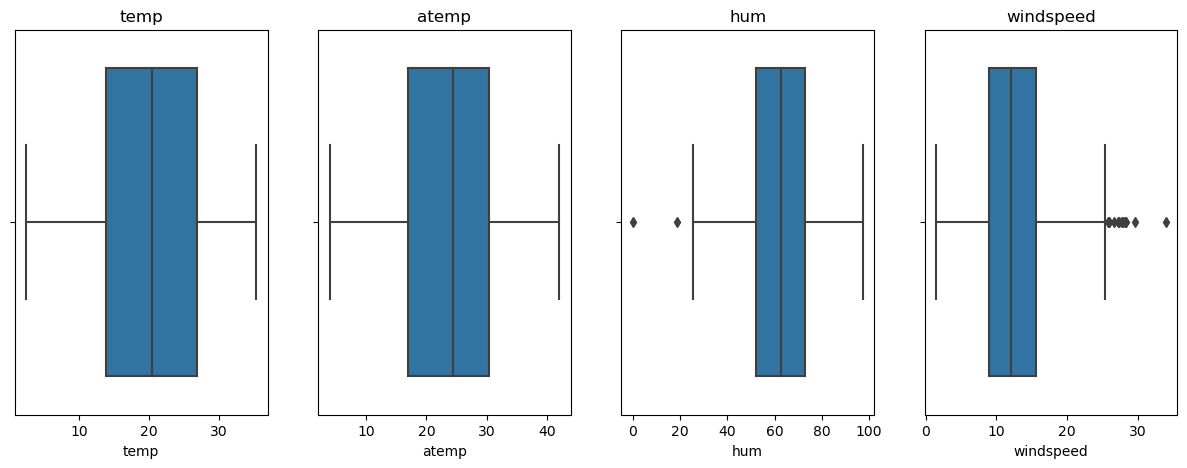

In [10]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
for idx,i in enumerate(['temp','atemp','hum','windspeed']) : 
    sns.boxplot(x=df[i],ax=ax[idx])
    ax[idx].set_title(i)
plt.show()

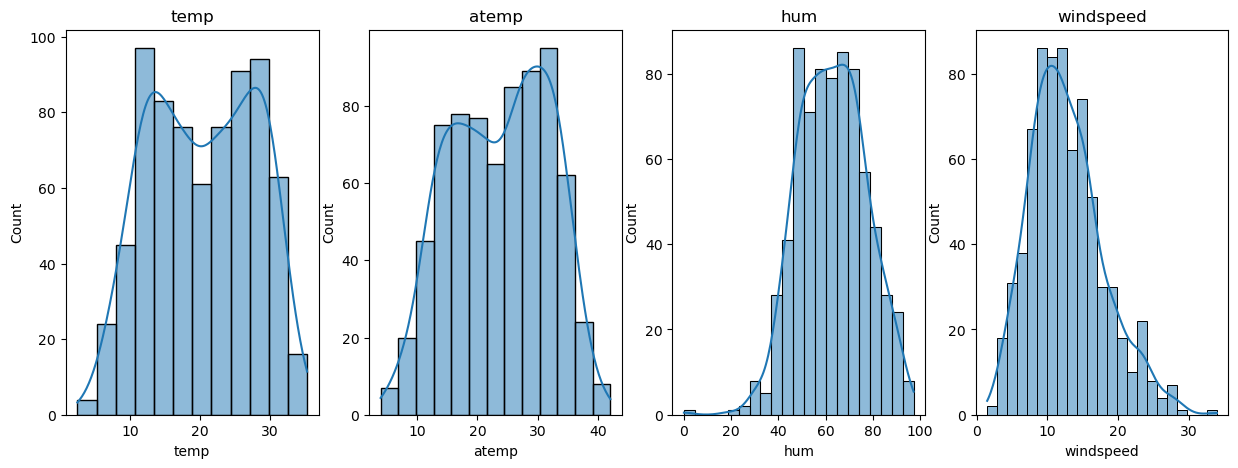

In [11]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
for idx,i in enumerate(['temp','atemp','hum','windspeed']) : 
    sns.histplot(x=df[i],ax=ax[idx],kde=True)
    ax[idx].set_title(i)
plt.show()

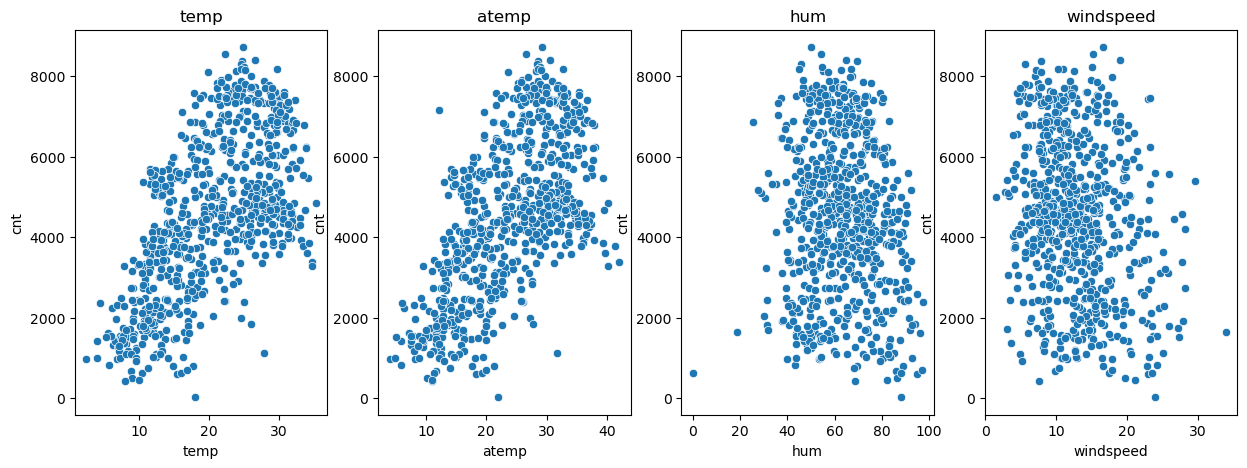

In [12]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
for idx,i in enumerate(['temp','atemp','hum','windspeed']) : 
    sns.scatterplot(x=df[i],y=df['cnt'],ax=ax[idx])
    ax[idx].set_title(i)
plt.show()

- temp and atemp seem to affect cnt in the same way which is expected
- Similar behavior can be seen with humidity and windspeed

<Axes: xlabel='hum', ylabel='windspeed'>

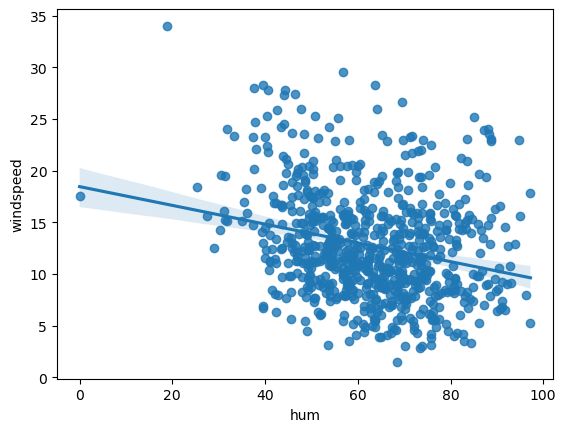

In [13]:
sns.regplot(x=df['hum'],y=df['windspeed'])

- Create feature Temperature Humidity Index which captures both humidity and temperature in a single feature
- THW = HI - (1.072 * W)

In [14]:
df['thw'] = df['hum'] - (1.072 * df['windspeed'])

- Though the column thw was derived it can be observed from the corr matrix that there is very poor relationship between thw and cnt and so is the case with hum 
- drop both hum and thw

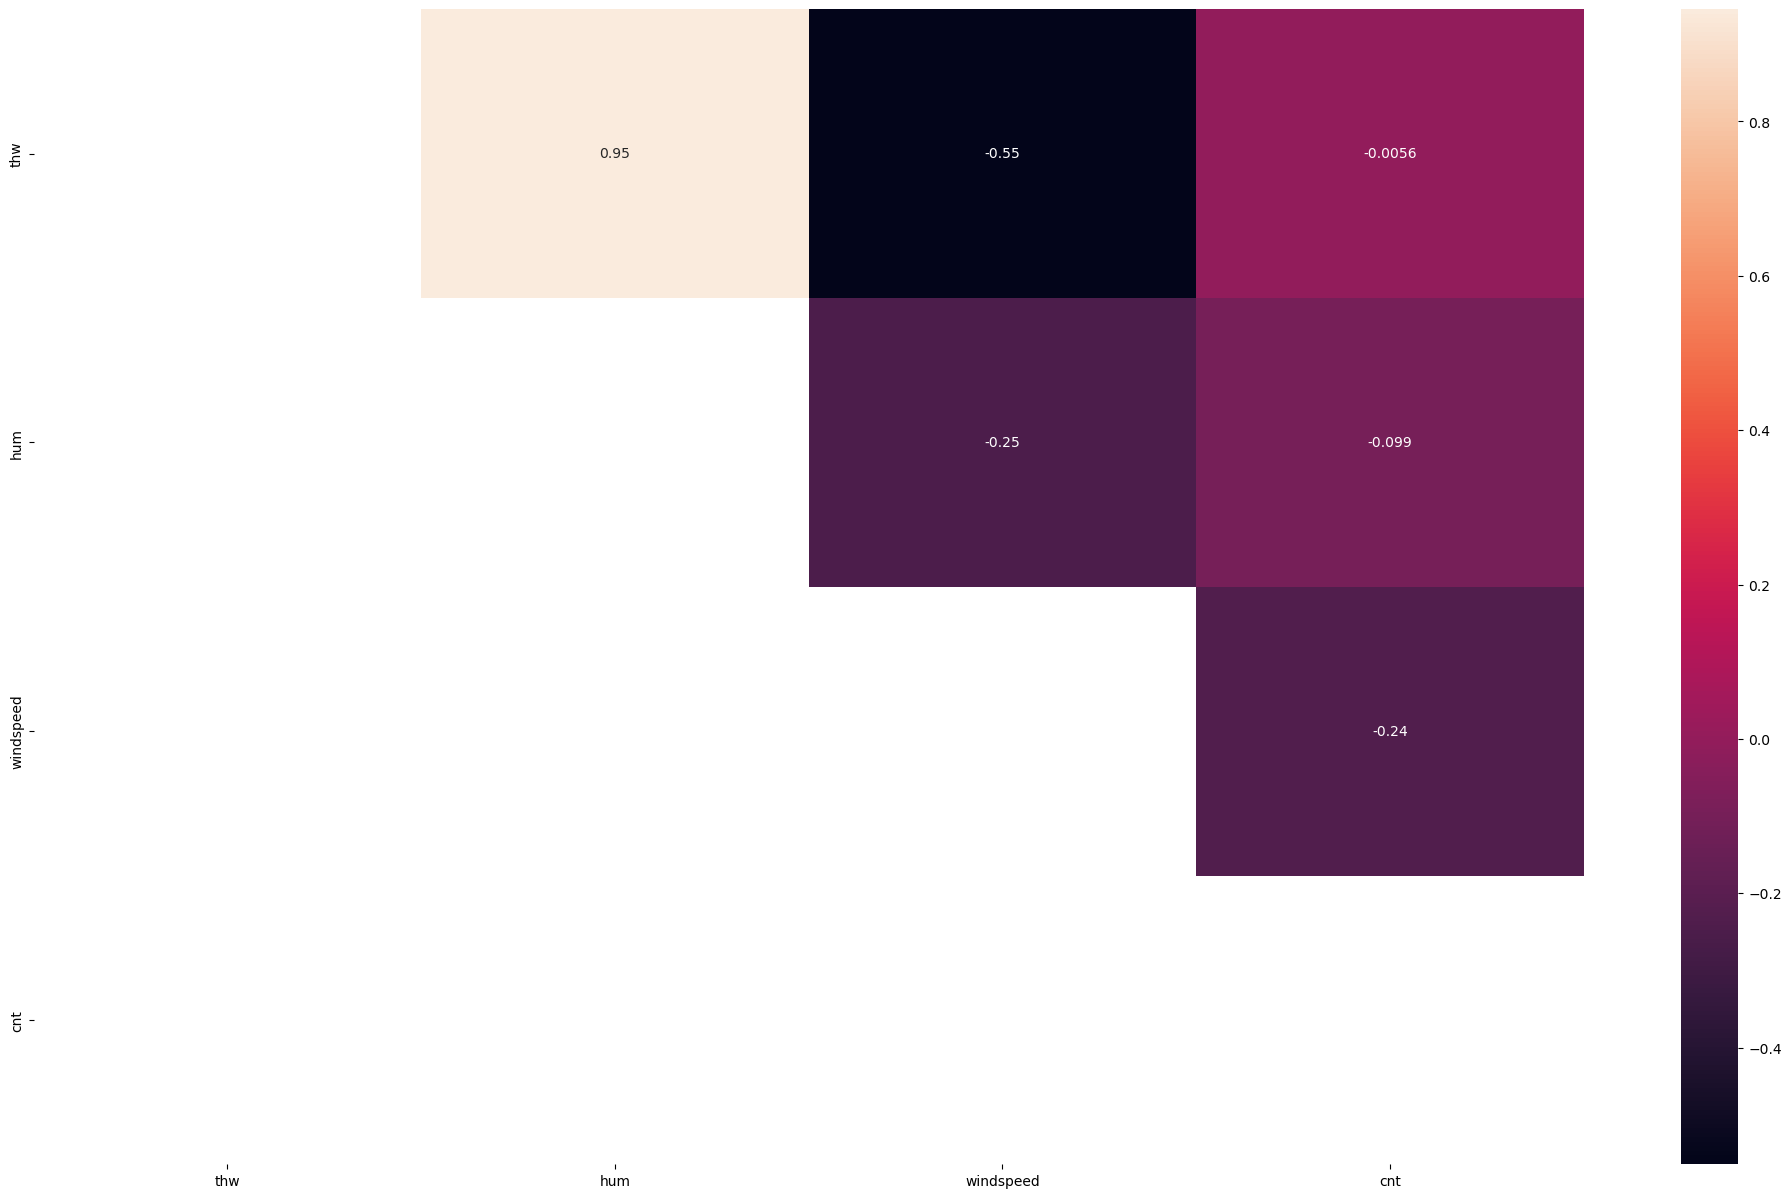

In [15]:
corr_mat = df[['thw','hum','windspeed','cnt']]
plt.figure(figsize=(25,15))
corr_matrix = corr_mat.corr().where(np.triu(np.ones(corr_mat.corr().shape),k=1).astype('bool'))
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [16]:
# drop columns humidity and thw
df = df.drop(['hum','thw'],axis=1)

- The seasons column seems to be represented as an ordinal variable
- There is no clear order to the seasons column , hence this shouldn't be ordinal
- Since regression model doesn't take categorical variables ,dummy encode these variables 
- Point to be noted here is that when applying the dummy encoding it is a good practice to take n-1 features when there are n     variables . This is because (n-1) features are enough to explain all possible scenarios , making the nth feature highly     correlated to the other 1,..,n-1 features. 
- Multi Collinearity can confuse the model ,by making it too complex , another way to interpret it would be that in linear regression coefficient m1 explains the behavior of y as x1 varies , while all other parameters are held constant . This fundamental interpretability of linear regression doesn't hold 

In [17]:
# The seasons variable contains 4 values
df['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [18]:
convert_to_categorical = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
df['season'] = df['season'].replace(convert_to_categorical)
df['season'].unique()

array(['spring', 'summer', 'fall', 'winter'], dtype=object)

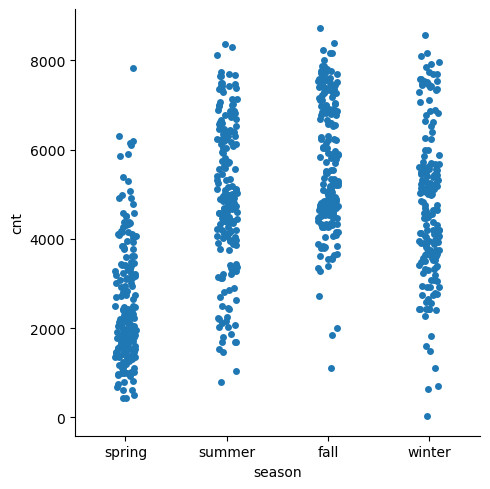

In [19]:

sns.catplot(data=df,x='season',y='cnt')


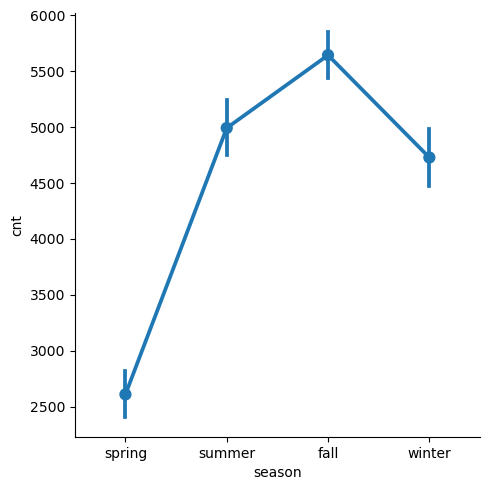

In [20]:
sns.catplot(data=df,x='season',y='cnt',estimator='mean',kind='point')

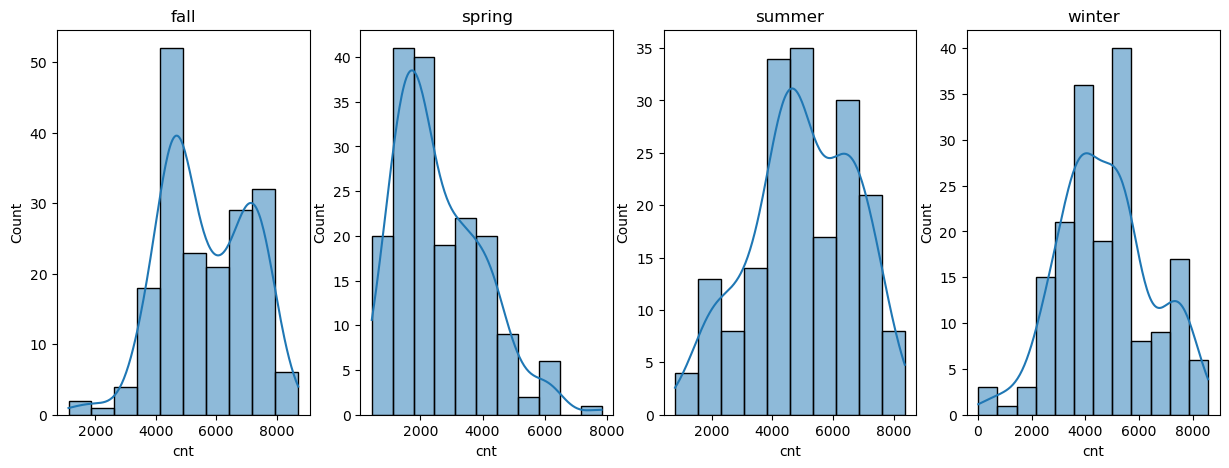

In [21]:
fig,ax = plt.subplots(1,4,figsize=(15,5))
for idx,(sidx,seasons) in enumerate(df.groupby(['season'])) : 
    sns.histplot(data=seasons,x='cnt',kde=True,ax=ax[idx])
    ax[idx].set_title(sidx)
plt.show()

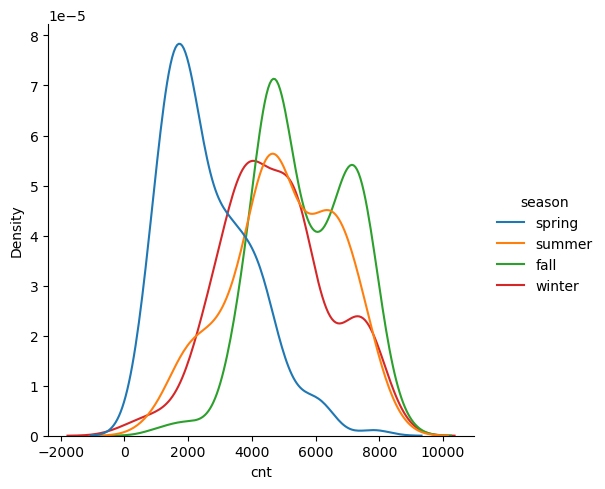

In [22]:
sns.displot(data=df,x='cnt',hue='season',kind='kde')

- There seems to be positive linear relationship in the order spring->winter->summer->fall

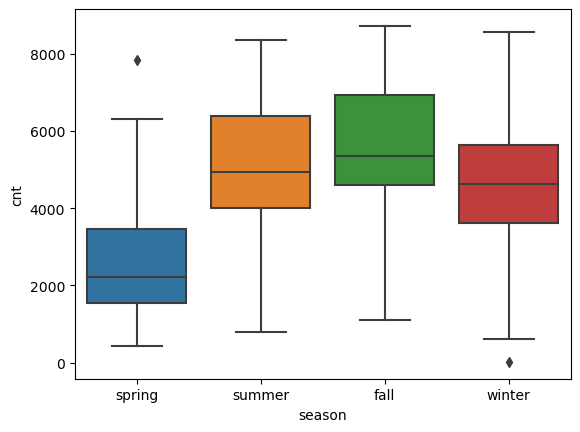

In [23]:
sns.boxplot(data=df,y='cnt',x='season')
plt.show()

In [24]:
# The weathersits variable contains 4 values
df['weathersit'].unique()

array([2, 1, 3], dtype=int64)

In [25]:
convert_to_categorical = {i : 'weathersit_' + str(i)  for i in df['weathersit'].unique()}
df['weathersit'] = df['weathersit'].replace(convert_to_categorical)
df['weathersit'].unique()

array(['weathersit_2', 'weathersit_1', 'weathersit_3'], dtype=object)

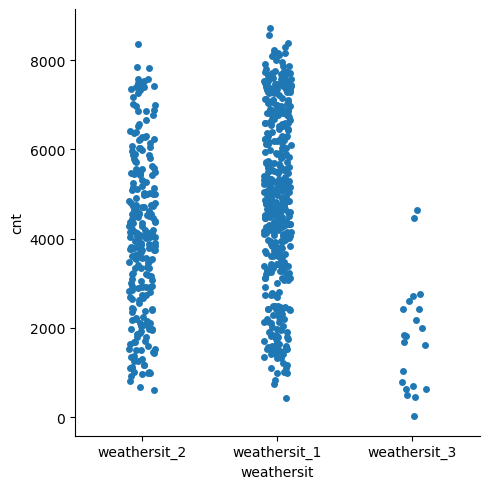

In [26]:

sns.catplot(data=df,x='weathersit',y='cnt',estimator='median')


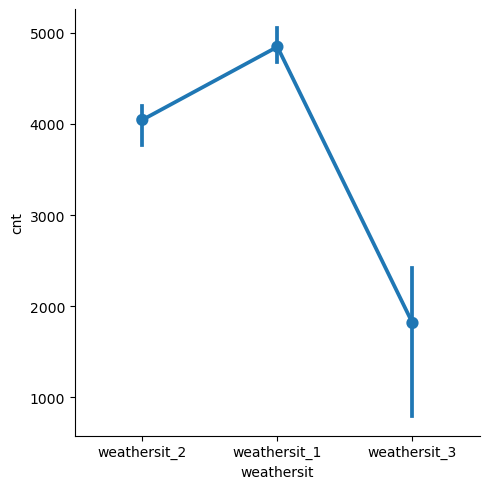

In [27]:
sns.catplot(data=df,x='weathersit',y='cnt',estimator='median',kind='point')

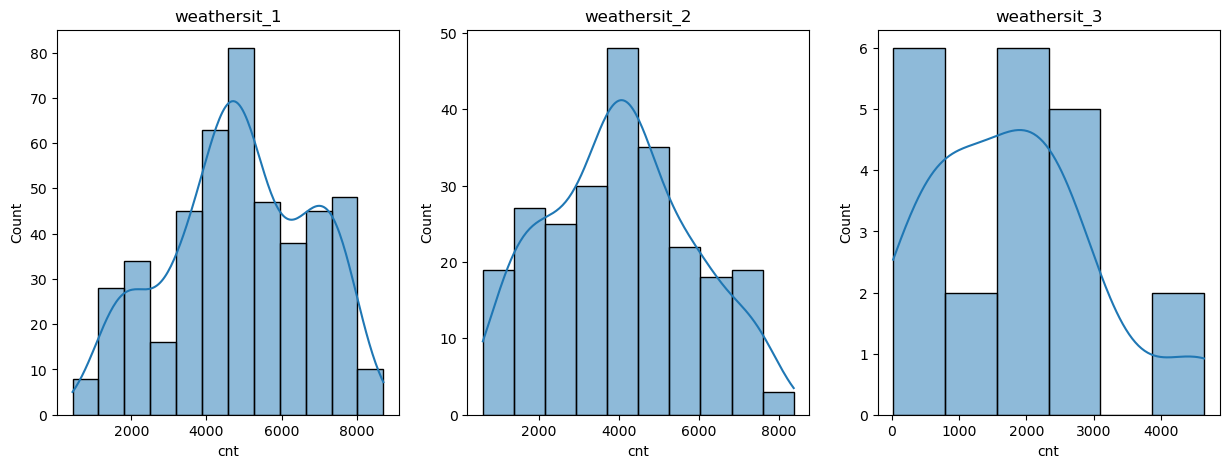

In [28]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for idx,(sidx,weather) in enumerate(df.groupby(['weathersit'])) : 
    sns.histplot(data=weather,x='cnt',kde=True,ax=ax[idx])
    ax[idx].set_title(sidx)
plt.show()

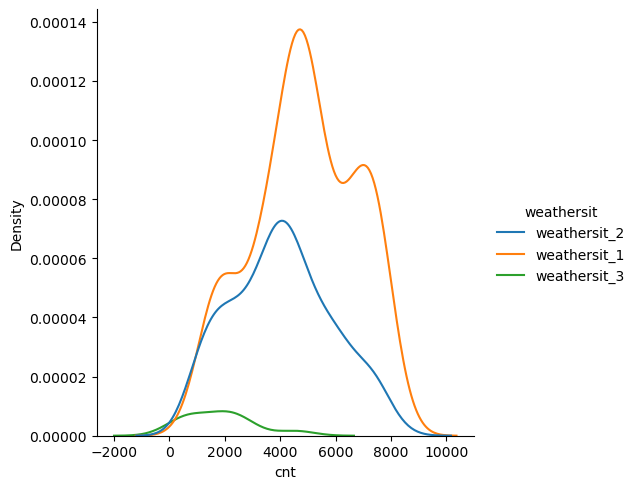

In [29]:
sns.displot(data=df,x='cnt',hue='weathersit',kind='kde')

- here too here seems to be a positive linear correlation in the order of weather3->weahter-2->weather-1

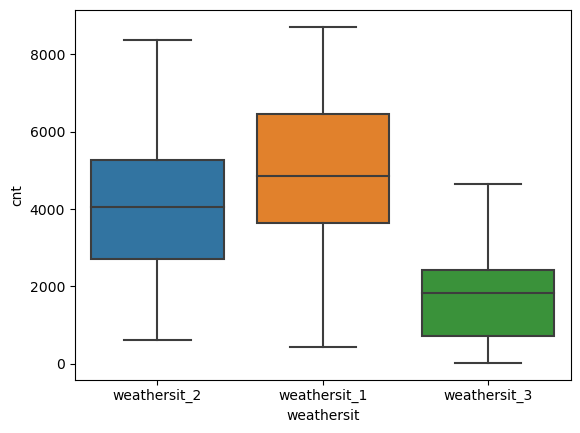

In [30]:
sns.boxplot(data=df,y='cnt',x='weathersit')
plt.show()

In [31]:
num_to_week_day = {1 : 'monday',2 : 'tuesday',3 : 'wednesday',4 : 'thrusday',5 : 'friday',6:'saturday',0:'sunday' }
df['weekday']=df['weekday'].replace(num_to_week_day)

In [32]:
df['weekday'].value_counts()

saturday     105
sunday       105
monday       105
tuesday      104
thrusday     104
friday       104
wednesday    103
Name: weekday, dtype: int64

In [33]:
df['weekday'] = df['weekday'].astype('category').cat.set_categories(['sunday','monday','tuesday','wednesday','thrusday','friday','saturday'],ordered=True)

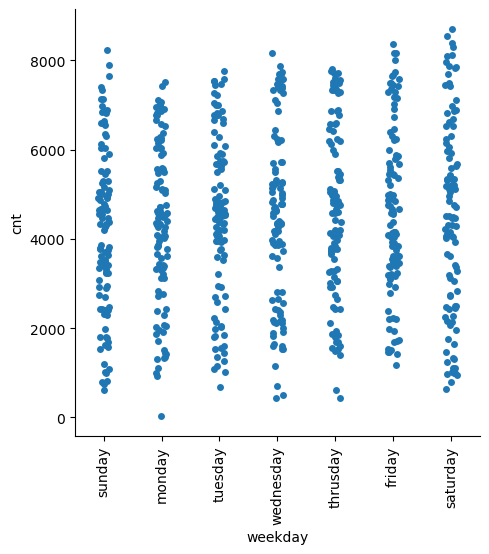

In [34]:

sns.catplot(data=df,x='weekday',y='cnt',estimator='mean')
plt.xticks(rotation=90)
plt.show()

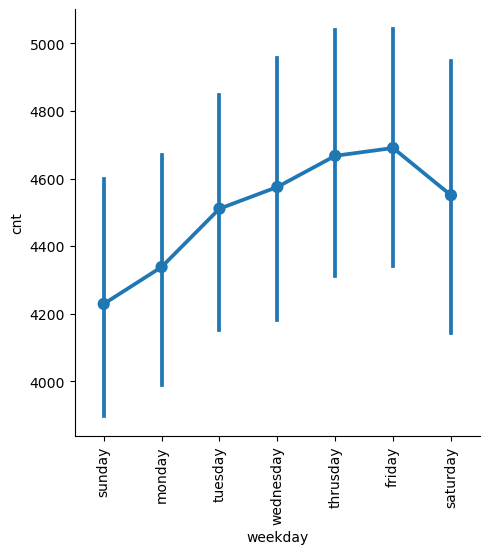

In [35]:
# order_weekday = df.groupby(['weekday'])['cnt'].mean().sort_values().index
sns.catplot(data=df,x='weekday',y='cnt',estimator='mean',kind='point',order=None)
plt.xticks(rotation=90)
plt.show()

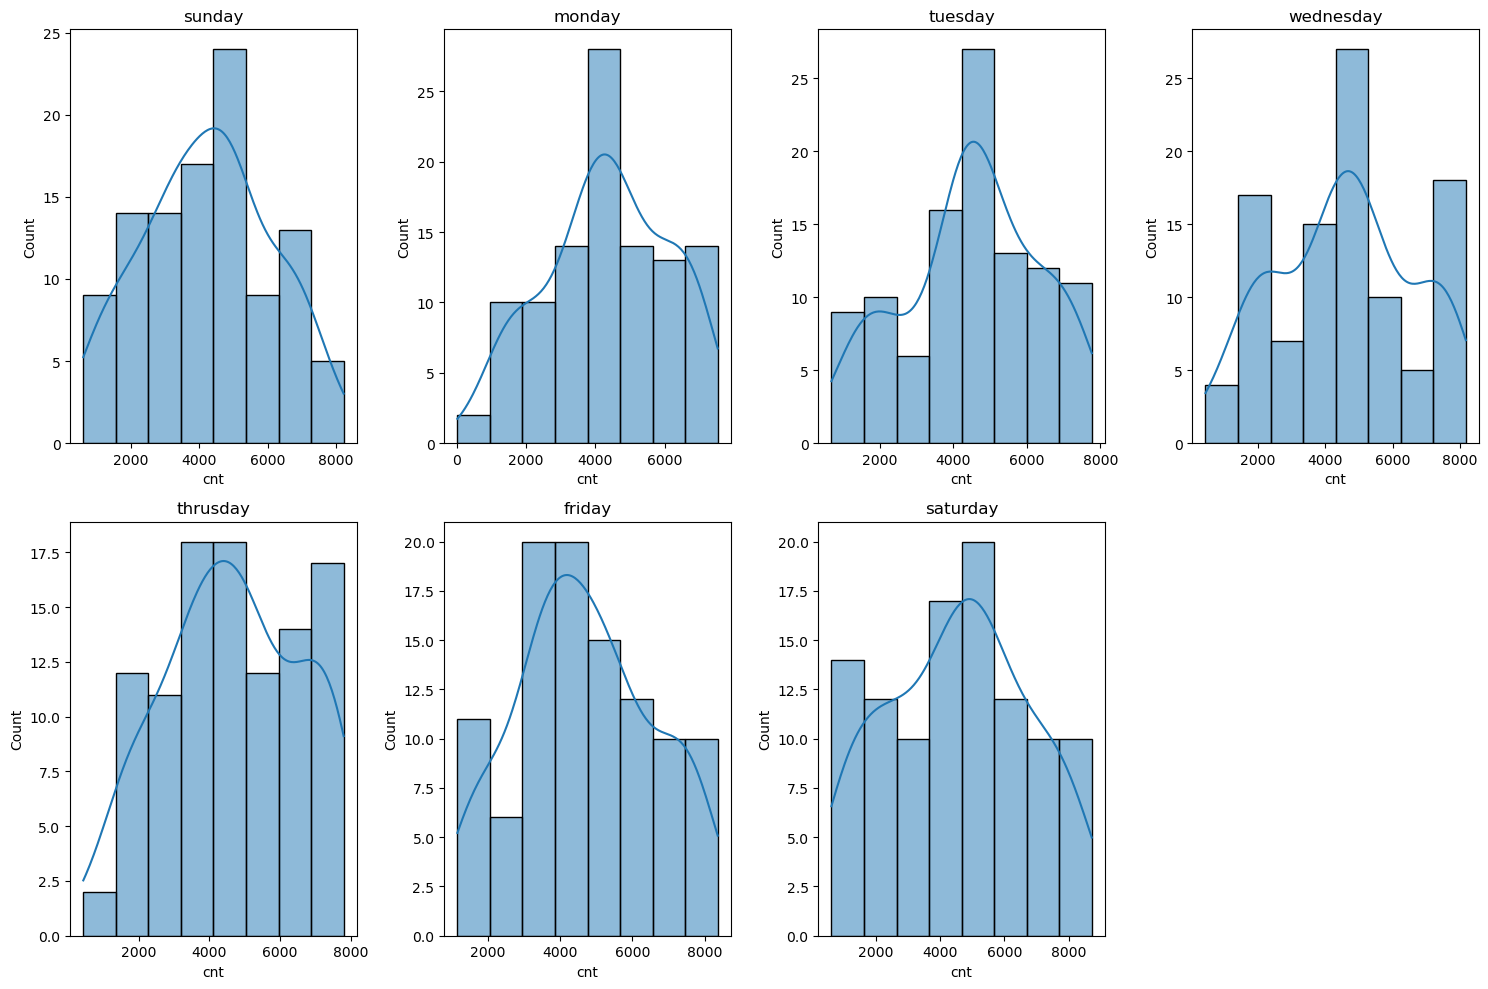

In [36]:
xm = 2
ym = 4
fig,ax = plt.subplots(xm,ym,figsize=(15,10))
# ax.axis('off')
# ax = ax.reshape(-1,1)
for idx,(sidx,week) in enumerate(df.groupby(['weekday'])) :
    gc = idx % ym
    gr = idx // ym
    sns.histplot(week['cnt'],kde=True,ax=ax[gr,gc])
    ax[gr,gc].set_title(sidx)
[fig.delaxes(i) for i in ax.flat if not i.has_data()]
plt.tight_layout()
plt.show()

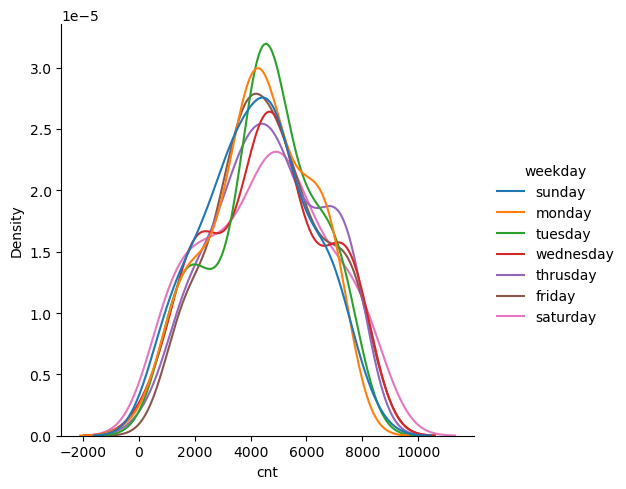

In [37]:
sns.displot(data=df,x='cnt',hue='weekday',kind='kde')

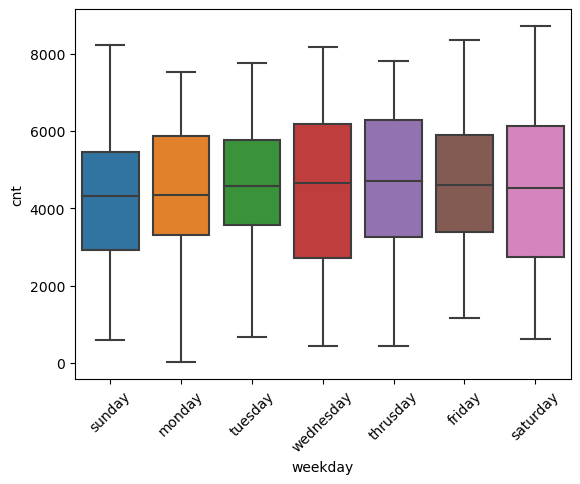

In [38]:
sns.boxplot(data=df,y='cnt',x='weekday',order = None)
plt.xticks(rotation=45)
plt.show()

In [39]:
df['weekday']

0       saturday
1         sunday
2         monday
3        tuesday
4      wednesday
         ...    
725     thrusday
726       friday
727     saturday
728       sunday
729       monday
Name: weekday, Length: 730, dtype: category
Categories (7, object): ['sunday' < 'monday' < 'tuesday' < 'wednesday' < 'thrusday' < 'friday' < 'saturday']

In [40]:
df[df['workingday'] == 0][df['holiday']== 0]['weekday'].unique()

['saturday', 'sunday']
Categories (7, object): ['sunday' < 'monday' < 'tuesday' < 'wednesday' < 'thrusday' < 'friday' < 'saturday']

- Let's say today is a working day , in that case holiday = 0 , workingday =1 and weekday has one of the 7 days
- Today is a holiday , in that case holiday = 1 , workingday = 0 , weekday has one of the 7 days
- Today is a weekend , in that case holiday = 0 , workingday = 0 , weekday has to be saturday or sunday

In [41]:
df['mnth'] = df['dteday'].dt.month_name()

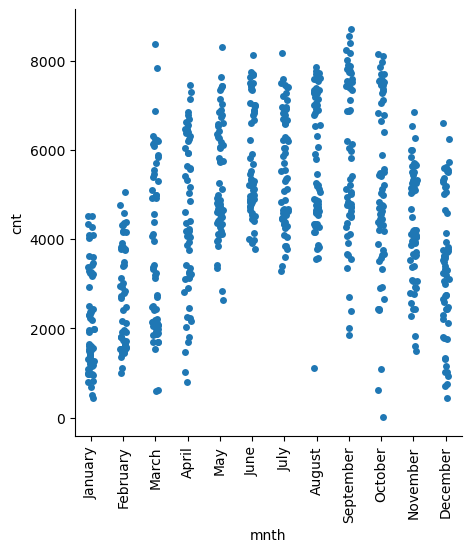

In [42]:

sns.catplot(data=df,x='mnth',y='cnt',estimator='mean')
plt.xticks(rotation=90)
plt.show()

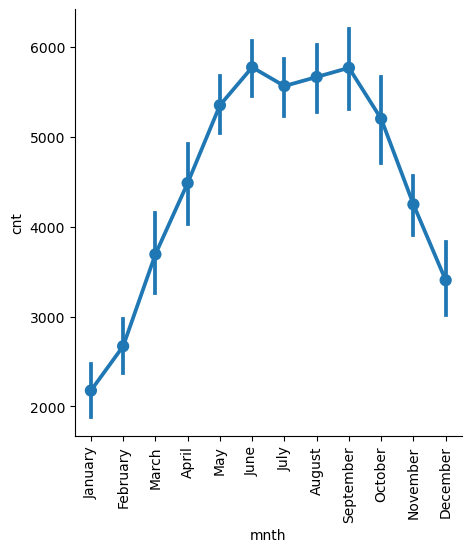

In [43]:
# order_month = df.groupby(['mnth'])['cnt'].mean().sort_values().index
sns.catplot(data=df,x='mnth',y='cnt',estimator='mean',kind='point',order=None)
plt.xticks(rotation=90)
plt.show()

In [44]:
df['mnth'] = df['mnth'].astype("category").cat.set_categories(df['mnth'].unique(),ordered=True)

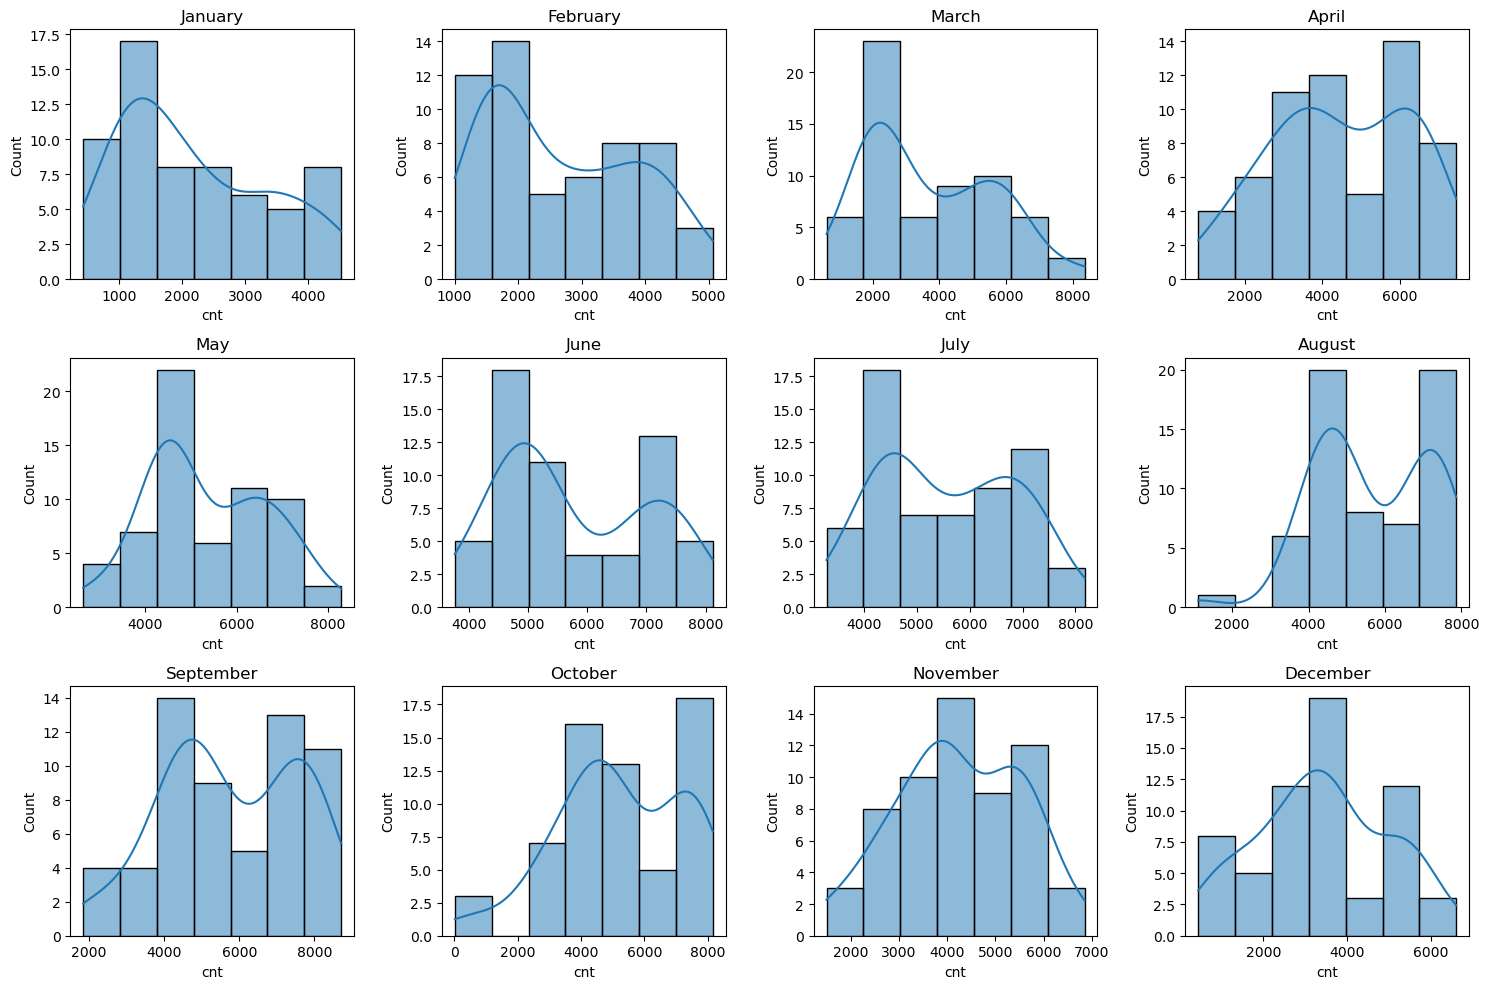

In [45]:
xm = 3
ym = 4
fig,ax = plt.subplots(xm,ym,figsize=(15,10))
# ax.axis('off')
# ax = ax.reshape(-1,1)
for idx,(sidx,month) in enumerate(df.groupby(['mnth'])) :
    gc = idx % ym
    gr = idx // ym
    sns.histplot(month['cnt'],kde=True,ax=ax[gr,gc])
    ax[gr,gc].set_title(sidx)
[fig.delaxes(i) for i in ax.flat if not i.has_data()]
plt.tight_layout()
plt.show()

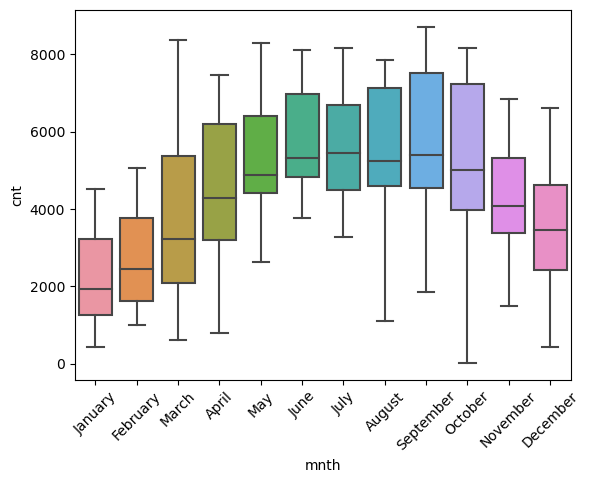

In [46]:
sns.boxplot(data=df,y='cnt',x='mnth',order = None)
plt.xticks(rotation=45)
plt.show()

In [47]:
# Dummy encoding categorical variables
df = pd.concat([df,pd.get_dummies(df['season'],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df['weathersit'],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekday'],drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df['mnth'],drop_first=True)],axis=1)

In [48]:
# drop the seasons column as all information in the feature has been captured
df = df.drop(['season','weathersit','weekday','mnth'],axis=1)

In [49]:
#dteday spans over 2 years
df['dteday'].dt.year.unique()

array([2018, 2019], dtype=int64)

In [50]:
df['yr'].value_counts()

0    365
1    365
Name: yr, dtype: int64

- It is clear that 2018 is being represented by 0 and 2019 by 1 
- convert year to dummy variable 
- it can also be observed that the no.of rentals are increasing over the years


<Axes: xlabel='yr', ylabel='cnt'>

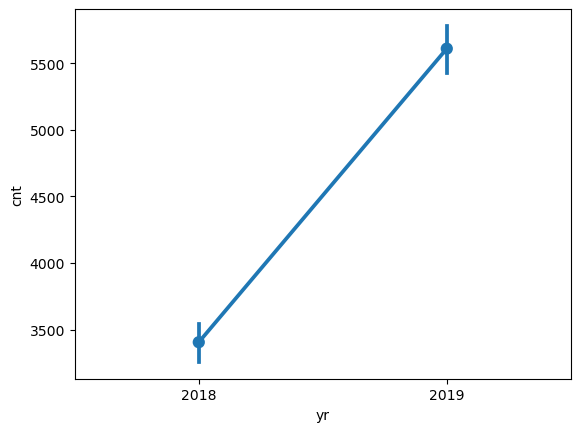

In [51]:
sns.pointplot(x=df['yr'].replace({0:2018,1:2019}),y=df['cnt'])

In [52]:
df = df.drop(columns = 'dteday')


In [53]:
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'windspeed', 'casual',
       'registered', 'cnt', 'spring', 'summer', 'winter', 'weathersit_2',
       'weathersit_3', 'monday', 'tuesday', 'wednesday', 'thrusday', 'friday',
       'saturday', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object')

In [54]:
# Remove the columns casual and registered because their sum is basically the target column , such columns are not usually present in real time predictions as these are target data
df = df.drop(columns = ['casual','registered'])

In [55]:
re_order_columns = list(df.columns[~df.columns.str.contains('cnt')]) + ['cnt']
re_order_columns


['yr',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'windspeed',
 'spring',
 'summer',
 'winter',
 'weathersit_2',
 'weathersit_3',
 'monday',
 'tuesday',
 'wednesday',
 'thrusday',
 'friday',
 'saturday',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 'cnt']

In [56]:
df = df[re_order_columns]

In [57]:
df.shape

(730, 29)

- It can be inferred from the heatmap that yr,temp,atemp have a high positive correlation betweem yr,temp and atemp
- It can also be seen that there is a very high positive correlation  between temp and atemp 
- Collinearity causes problems in the way linear regression works (causes issues with interpretability)
- Hence either temp or atemp must be removed

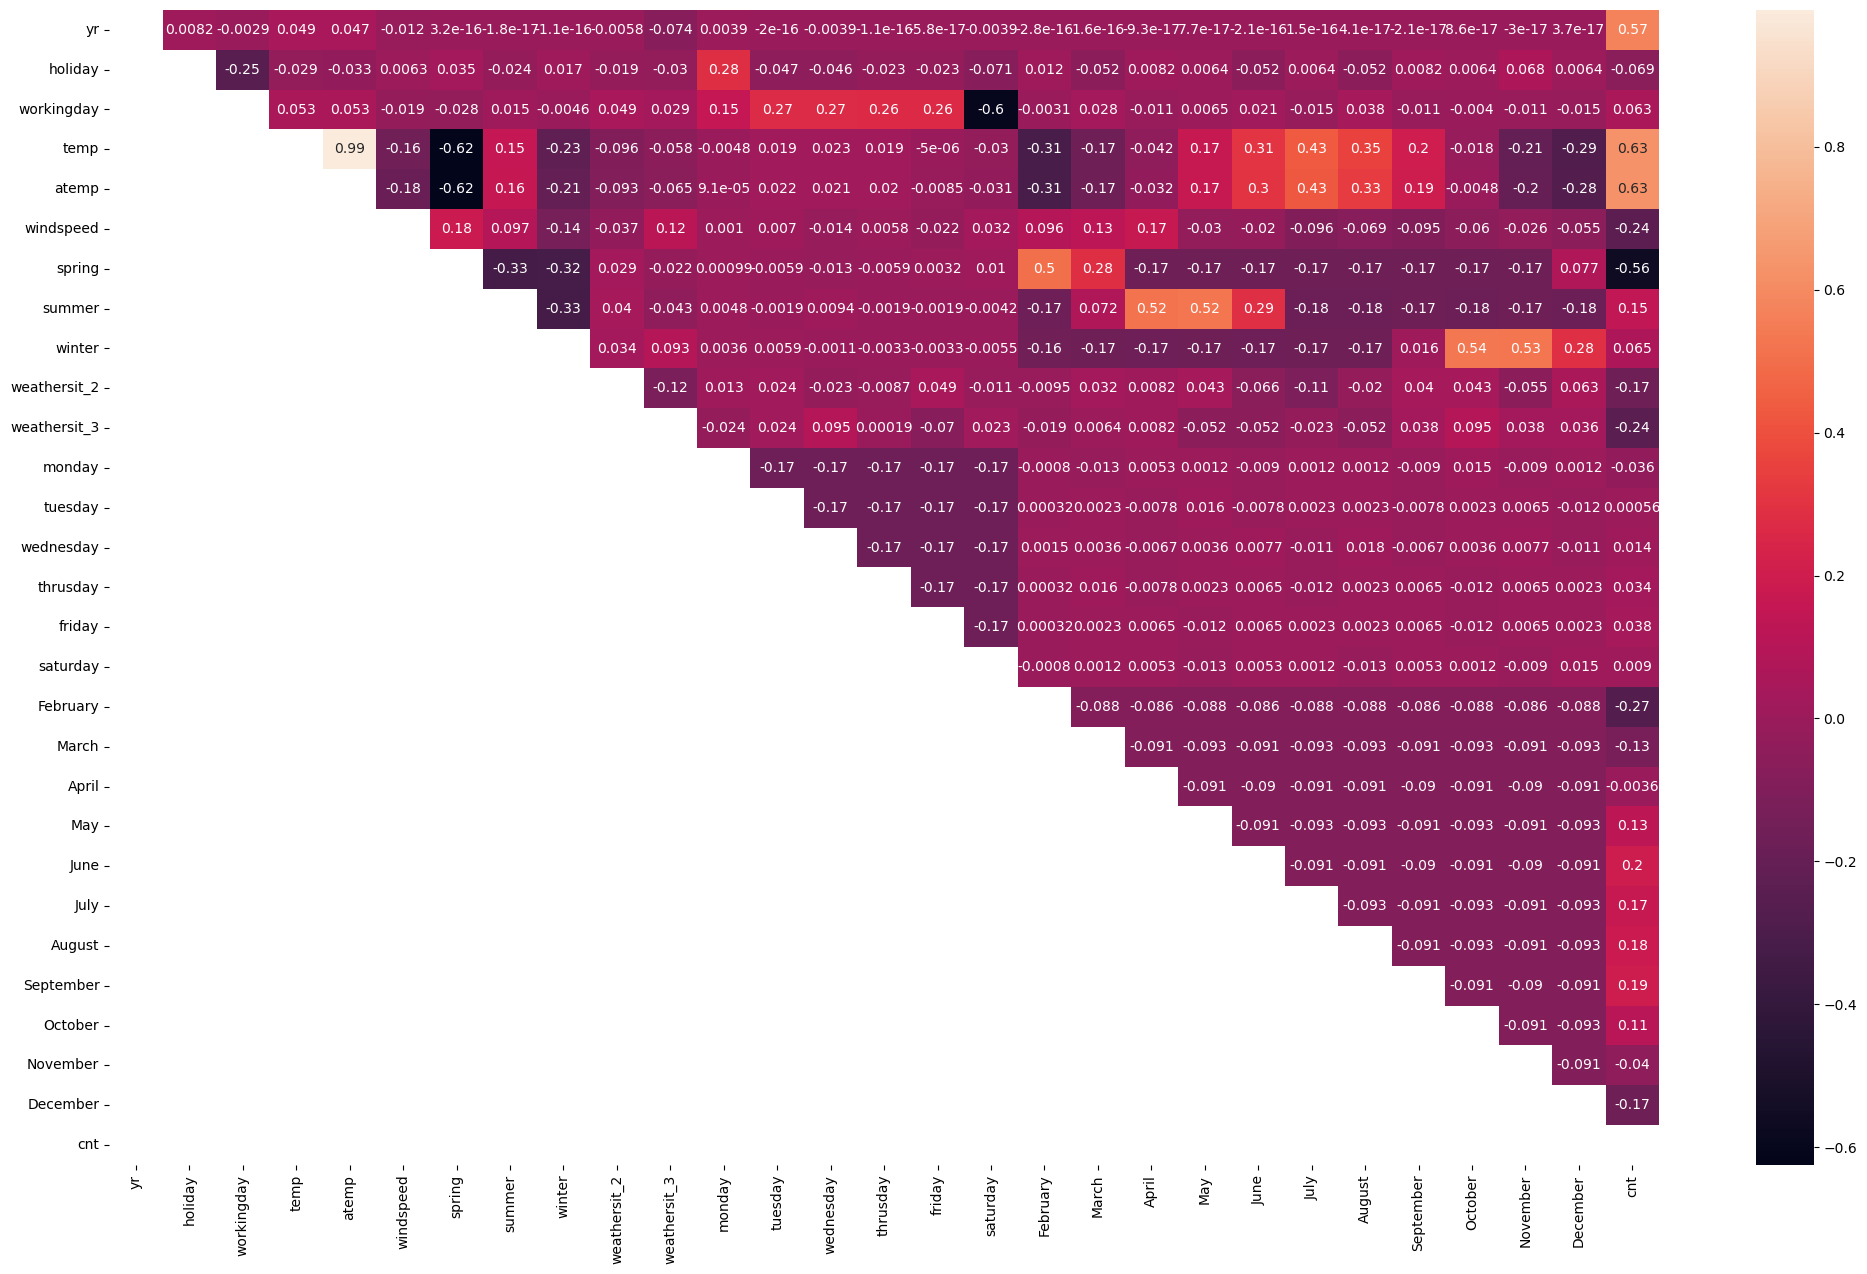

In [58]:
plt.figure(figsize=(25,15))
corr_matrix = df.corr().where(np.triu(np.ones(df.corr().shape),k=1).astype('bool'))
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [59]:
# Saturday seems to have a high correlation with workingdays , this can lead multi-collinearity hence remove
df = df.drop(columns='saturday')

In [60]:
# Filter out dummy encoded values as it doesn't make sense to measure correlation on these variables
corr_mat = df[[ 'temp', 'atemp',
       'windspeed','cnt']]

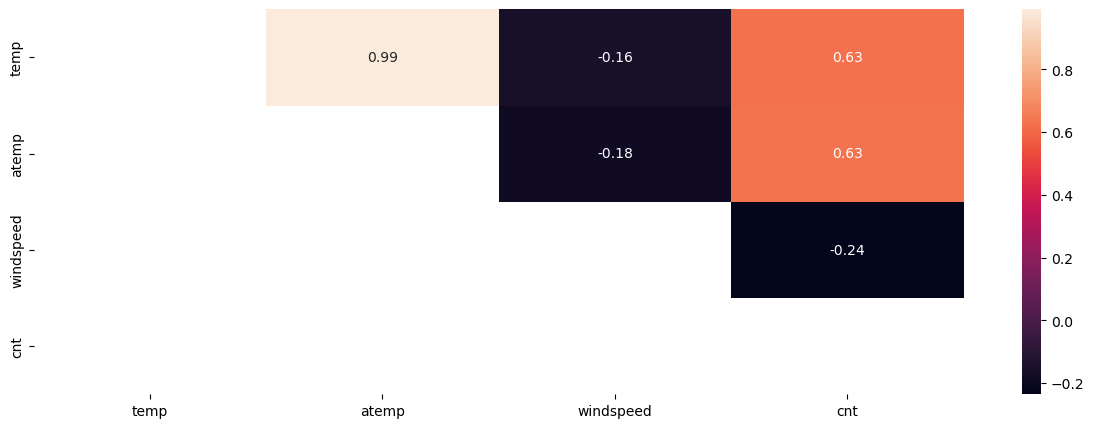

In [61]:
# Remove the lower triangle and the diagonal of the correlation matrix as it is symetric 
plt.figure(figsize=(15,5))
corr_matrix = corr_mat.corr().where(np.triu(np.ones(corr_mat.corr().shape),k=1).astype('bool'))
sns.heatmap(corr_matrix,annot=True)
plt.show()

In [62]:
# dropping atemp because it is highly correlated 
df = df.drop(columns = 'atemp')

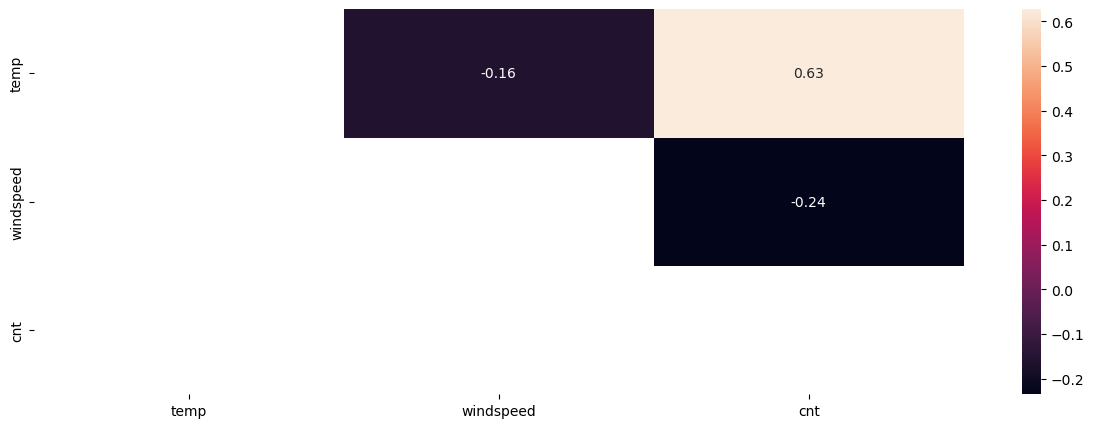

In [63]:
plt.figure(figsize=(15,5))
corr_mat= corr_mat.drop(columns = 'atemp')
corr_matrix = corr_mat.corr().where(np.triu(np.ones(corr_mat.corr().shape),k=1).astype('bool'))
sns.heatmap(corr_matrix,annot=True)
plt.show()

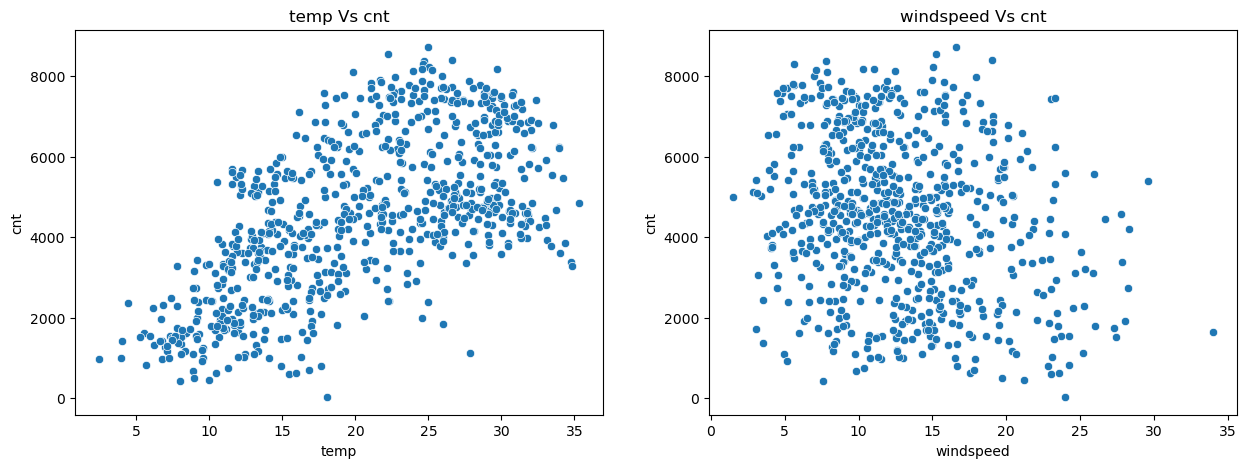

In [64]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
for idx,i in enumerate(['temp', 'windspeed']) : 
    sns.scatterplot(data=df,x=i,y='cnt',ax=ax[idx])
    ax[idx].set_title('{} Vs cnt'.format(i))
plt.show()

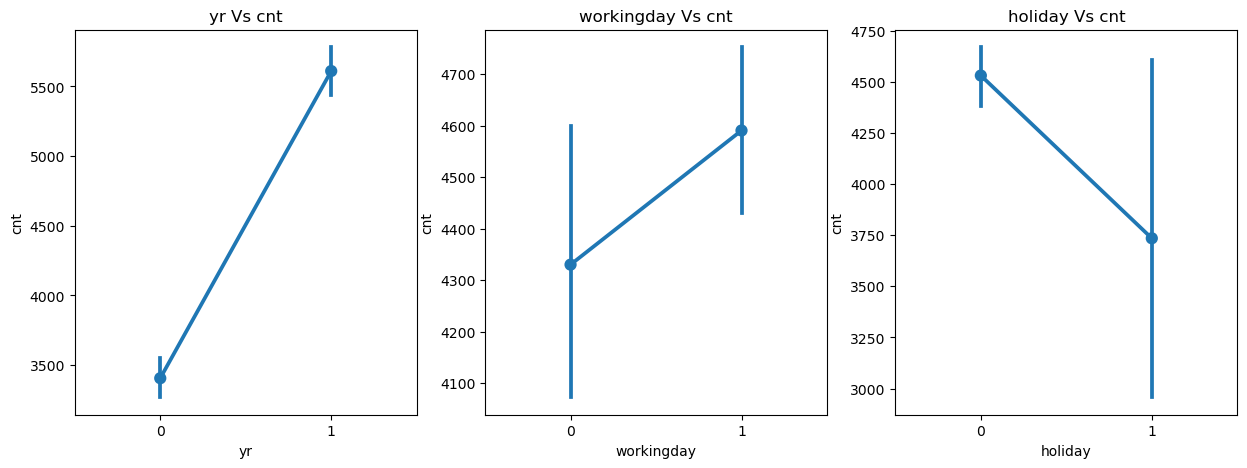

In [65]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for idx,i in enumerate(['yr', 'workingday','holiday']) : 
    sns.pointplot(data=df,x=i,y='cnt',ax=ax[idx])
    ax[idx].set_title('{} Vs cnt'.format(i))
plt.show()

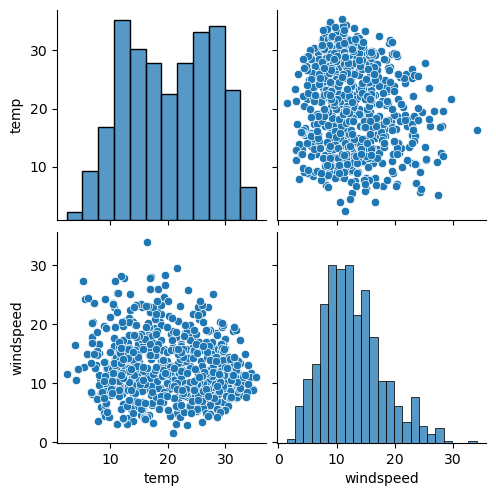

In [66]:
# Altohugh here a shadow of a linear relationship can be observed this isn't clearly visible as there is a good degree of variance
sns.pairplot(df[['temp', 'windspeed']])

- Minmax scaler was used here 
- The scaler handles outliers if any and brings data into a scale of 0 to 1 
- This prevents overfitting , i.e giving too much weights to certain features
- In this case , though data is pretty much on a similar scale , so adding scaler shouldn't make too much difference

In [67]:
def get_model_ready(df) : 
    df1 = df.copy()
    y = df1.pop("cnt")
    X = df1
    X_train,X_test,y_train,y_test  = train_test_split(X,y,train_size=0.7, random_state=100)
    cols = X_train.columns
    scaler = MinMaxScaler()
    num_features = ['temp','windspeed']
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    X_train2 = scaler.fit_transform(X_train[num_features])
    X_test2 = scaler.transform(X_test[num_features])
    X_train2 = pd.DataFrame(X_train2,columns=num_features)
    X_test2 = pd.DataFrame(X_test2,columns=num_features)
    X_train = X_train.drop(columns = num_features)
    X_test = X_test.drop(columns = num_features)
    X_train = pd.concat([X_train,X_train2],axis=1)
    X_test = pd.concat([X_test,X_test2],axis=1)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    return X_train,X_test,y_train,y_test

In [68]:
X_train,X_test,y_train,y_test = get_model_ready(df)

In [69]:
X_train

yr  holiday  workingday  spring  summer  winter  weathersit_2  \
0     1        0           1       0       0       0             0   
1     1        0           0       1       0       0             1   
2     1        0           0       1       0       0             0   
3     1        0           0       0       1       0             1   
4     0        0           1       0       1       0             1   
..   ..      ...         ...     ...     ...     ...           ...   
505   1        0           1       0       0       0             0   
506   0        0           1       1       0       0             0   
507   0        0           0       0       0       1             1   
508   0        0           1       0       1       0             1   
509   1        0           1       0       1       0             1   

     weathersit_3  monday  tuesday  ...  May  June  July  August  September  \
0               0       0        1  ...    0     0     1       0          0   
1               0       0        0  ...    0     0     0       0          0   
2               0       0        0  ...    0     0     0       0          0   
3               0       0        0  ...    0     0     0       0          0   
4               0       0        0  ...    0     0     0       0          0   
..            ...     ...      ...  ...  ...   ...   ...     ...        ...   
505             0       0        0  ...    0     0     0       1          0   
506             0       0        0  ...    0     0     0       0          0   
507             0       0        0  ...    0     0     0       0          0   
508             0       1        0  ...    0     0     0       0          0   
509             0       0        1  ...    0     1     0       0          0   

     October  November  December      temp  windspeed  
0          0         0         0  0.815169   0.264686  
1          0         0         0  0.442393   0.255342  
2          0         0         1  0.245101   0.663106  
3          0         0         0  0.395666   0.188475  
4          0         0         0  0.345824   0.380981  
..       ...       ...       ...       ...        ...  
505        0         0         0  0.863973   0.187140  
506        0         0         0  0.202618   0.111379  
507        0         0         1  0.248216   0.431816  
508        0         0         0  0.462664   0.529881  
509        0         0         0  0.600225   0.359599  

[510 rows x 26 columns]

In [70]:
print(f'noof features : {X_train.shape[1]}')

noof features : 26


#  Feature Selection I

   # Recursive Feature Elimination

In [71]:
def rfe_method(X_train,y_train,n) : 
    estimator  = linear_model.LinearRegression()
    rfe_feature_selection  = RFE(estimator, n_features_to_select=n, step=1)
    rfe_feature_selection = rfe_feature_selection.fit(X_train,y_train)
    rankings = rfe_feature_selection.ranking_
    support  = rfe_feature_selection.support_
    rfe_df = pd.DataFrame(data= {'features' : X_train.columns,'support' : support,'ranking' : rankings,})
    return rfe_df.sort_values(['ranking']),support

# Training using Stats Model

In [72]:
def stats_model_training(X_train,y_train) : 
    X_train_rfe = sm.add_constant(X_train)
    lm = sm.OLS(y_train,X_train_rfe).fit()
    return lm.summary()

In [73]:
def vif_method(X) : 
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [74]:
rfe_df,support = rfe_method(X_train.copy(),y_train.copy(),16)
rfe_df

features  support  ranking
0             yr     True        1
20     September     True        1
14         March     True        1
24          temp     True        1
11      thrusday     True        1
10     wednesday     True        1
9        tuesday     True        1
8         monday     True        1
12        friday     True        1
6   weathersit_2     True        1
1        holiday     True        1
7   weathersit_3     True        1
2     workingday     True        1
25     windspeed     True        1
3         spring     True        1
5         winter     True        1
16           May    False        2
15         April    False        3
17          June    False        4
19        August    False        5
21       October    False        6
4         summer    False        7
18          July    False        8
13      February    False        9
22      November    False       10
23      December    False       11

In [75]:
X_train = X_train[X_train.columns[support]]
X_test = X_test[X_test.columns[support]]

- If p(t) > 0.05 then that means we fail to reject the null hypothesis , hence the feature is insignificant remove it 
- if vif > 5 then there might be high multicollinearity , if vif > 10 then there is high multicollinearity for sure
- if vif < 5 then there is very low to no multicollinearity
- p(f-statistic) > 0.05 then that means we fail to reject the null hypothesis , hence the variance in the model isn't statistically significant

- In cases where there is high p-value and high vif-value for different features, prioritize taking care of the feature with high p-value , as vif can change as the feature set changes 

In [76]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     162.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.11e-179
Time:                        19:35:46   Log-Likelihood:                -4133.4
No. Observations:                 510   AIC:                             8299.
Df Residuals:                     494   BIC:                             8367.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2226.2992    215.157     10.347   

In [77]:
print(vif_method(X_train.copy()))

        Features   VIF
1        holiday   inf
2     workingday   inf
7         monday   inf
8        tuesday   inf
9      wednesday   inf
10      thrusday   inf
11        friday   inf
14          temp  4.71
15     windspeed  4.02
0             yr  2.06
3         spring  1.84
5   weathersit_2  1.53
4         winter  1.41
12         March  1.26
13     September  1.16
6   weathersit_3  1.09


In [78]:
# In the corr matrix it could be seen that there was a -0.25 correlation between holiday and workingday , since these cover all weekdays removing that should improve the relationship
X_train = X_train.drop(columns = 'holiday')

In [79]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     162.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.11e-179
Time:                        19:35:46   Log-Likelihood:                -4133.4
No. Observations:                 510   AIC:                             8299.
Df Residuals:                     494   BIC:                             8367.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2226.2992    215.157     10.347   

In [80]:
print(vif_method(X_train.copy()))

        Features    VIF
1     workingday  30.31
8      wednesday   8.58
7        tuesday   7.27
9       thrusday   7.03
10        friday   6.92
6         monday   6.57
13          temp   4.71
14     windspeed   4.02
0             yr   2.06
2         spring   1.84
4   weathersit_2   1.53
3         winter   1.41
11         March   1.26
12     September   1.16
5   weathersit_3   1.09


In [81]:
X_train = X_train.drop(columns = 'workingday')

In [82]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     169.7
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.30e-178
Time:                        19:35:46   Log-Likelihood:                -4138.7
No. Observations:                 510   AIC:                             8307.
Df Residuals:                     495   BIC:                             8371.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2235.1710    217.141     10.294   

In [83]:
print(vif_method(X_train.copy()))

        Features   VIF
12          temp  4.71
13     windspeed  4.02
0             yr  2.06
1         spring  1.83
3   weathersit_2  1.52
7      wednesday  1.50
5         monday  1.46
6        tuesday  1.41
8       thrusday  1.41
9         friday  1.41
2         winter  1.40
10         March  1.25
11     September  1.16
4   weathersit_3  1.09


In [84]:
X_train = X_train.drop(columns = 'monday')

In [85]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     183.0
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.09e-179
Time:                        19:35:46   Log-Likelihood:                -4138.8
No. Observations:                 510   AIC:                             8306.
Df Residuals:                     496   BIC:                             8365.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2212.3755    212.890     10.392   

In [86]:
print(vif_method(X_train.copy()))

        Features   VIF
11          temp  4.37
12     windspeed  4.00
0             yr  2.05
1         spring  1.79
3   weathersit_2  1.52
2         winter  1.38
6      wednesday  1.35
5        tuesday  1.29
7       thrusday  1.29
8         friday  1.29
9          March  1.25
10     September  1.16
4   weathersit_3  1.09


In [87]:
X_train = X_train.drop(columns = 'tuesday')

In [88]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     198.2
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.13e-180
Time:                        19:35:46   Log-Likelihood:                -4139.2
No. Observations:                 510   AIC:                             8304.
Df Residuals:                     497   BIC:                             8359.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2232.4604    211.671     10.547   

In [89]:
print(vif_method(X_train.copy()))

        Features   VIF
10          temp  4.10
11     windspeed  3.99
0             yr  2.05
1         spring  1.77
3   weathersit_2  1.51
2         winter  1.37
5      wednesday  1.27
8          March  1.25
6       thrusday  1.23
7         friday  1.22
9      September  1.16
4   weathersit_3  1.09


In [90]:
X_train = X_train.drop(columns = 'thrusday')

In [91]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     216.1
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.28e-181
Time:                        19:35:46   Log-Likelihood:                -4139.8
No. Observations:                 510   AIC:                             8304.
Df Residuals:                     498   BIC:                             8354.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2255.3180    210.527     10.713   

In [92]:
print(vif_method(X_train.copy()))

        Features   VIF
10     windspeed  3.99
9           temp  3.96
0             yr  2.05
1         spring  1.76
3   weathersit_2  1.51
2         winter  1.37
7          March  1.25
5      wednesday  1.23
6         friday  1.19
8      September  1.16
4   weathersit_3  1.09


In [93]:
X_train = X_train.drop(columns = 'wednesday')

In [94]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     236.4
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          3.96e-182
Time:                        19:35:46   Log-Likelihood:                -4141.4
No. Observations:                 510   AIC:                             8305.
Df Residuals:                     499   BIC:                             8351.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2286.1091    210.284     10.872   

In [95]:
print(vif_method(X_train.copy()))

       Features   VIF
9     windspeed  3.99
8          temp  3.83
0            yr  2.05
1        spring  1.74
3  weathersit_2  1.51
2        winter  1.36
6         March  1.25
5        friday  1.16
7     September  1.16
4  weathersit_3  1.08


In [96]:
X_train = X_train.drop(columns = 'friday')

In [97]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     261.5
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          8.72e-183
Time:                        19:35:46   Log-Likelihood:                -4142.7
No. Observations:                 510   AIC:                             8305.
Df Residuals:                     500   BIC:                             8348.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2304.1533    210.326     10.955   

In [98]:
print(vif_method(X_train.copy()))

       Features   VIF
8     windspeed  3.99
7          temp  3.75
0            yr  2.05
1        spring  1.73
3  weathersit_2  1.50
2        winter  1.36
5         March  1.25
6     September  1.16
4  weathersit_3  1.08


# Residual Analysis

In [99]:
X_train_rfe = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_rfe).fit()

In [100]:
y_pred_train = lm.predict(X_train_rfe)

In [101]:
(y_pred_train - y_train).mean()

2.7142175217615624e-12

- It can be seen that mean of the residuals is centered around zero(infestimally close to zero) which is in-line with the assumptions of linear regression

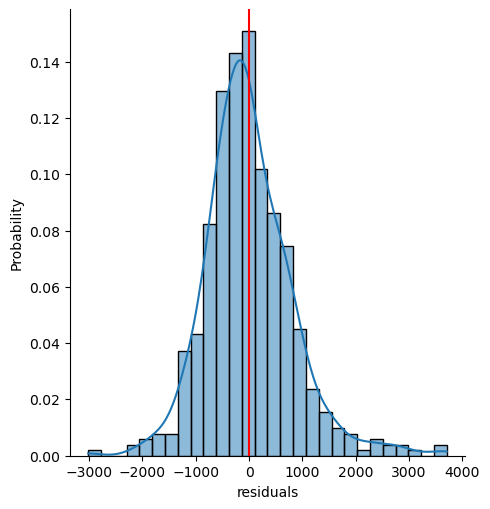

In [102]:
sns.displot(x=(y_pred_train - y_train),kde=True,stat='probability')
plt.xlabel('residuals')
plt.axvline(0,color='r')
plt.show()

- As seen except for a few points the variance of the model seems to be constant to a certain extent 
- It might be that by increasing the data or collecting data for a new feature might increase this 
- Also it might be possible to derive other features from the existing data 

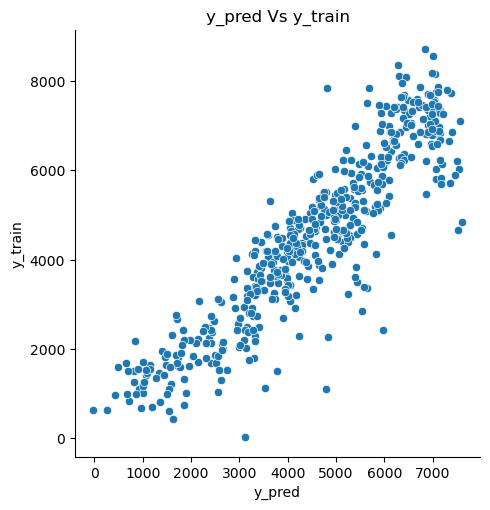

In [103]:
sns.relplot(x=y_pred_train,y=y_train,kind='scatter')
plt.title('y_pred Vs y_train')
plt.xlabel('y_pred')
plt.ylabel('y_train')
plt.show()

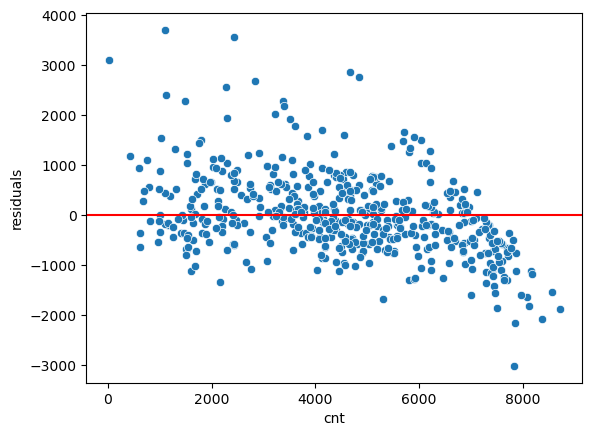

In [104]:
res  = (y_pred_train - y_train)
sns.scatterplot(x=y_train,y=res)
plt.axhline(res.mean(),color='red')
plt.ylabel('residuals')
plt.show()

- It can be inferred from the qq-plot that the residuals almost follow a normal distribution 
- It can be observed that the points are tappering off at the right tail

In [105]:
def plot_qq(res) : 
    qqplot(res,line='45',fit=True,dist=stats.norm)
    plt.show()


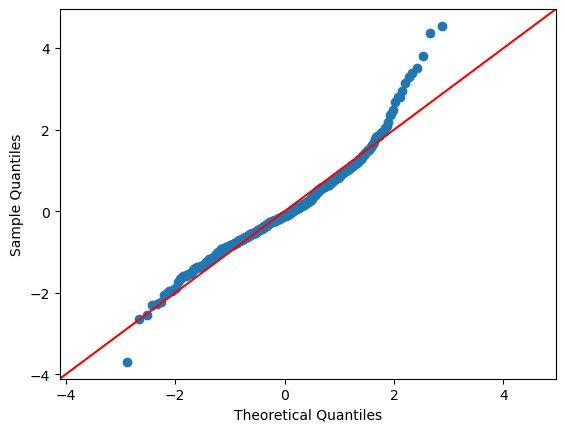

In [106]:
plot_qq(res)

In [107]:
X_test = X_test[X_train.columns]

# The r2-score for RFE is 0.77

In [108]:
X_test_lm = sm.add_constant(X_test)
y_pred = lm.predict(X_test_lm)
round(r2_score(y_pred,y_test),2)

0.77

# Deriving Model Metrics using sklearn

In [109]:
lr = linear_model.LinearRegression()

In [110]:
lr.fit(X_train,y_train)

LinearRegression()

# Model Evaluation

- The coefficients and the intercept of the sklearn linear regression model match that of the 

In [111]:
lr.coef_

array([ 2048.40445939, -1099.34169162,   406.56871108,  -655.6251204 ,
       -2488.93965742,   378.14056411,   590.94212992,  3572.05951191,
       -1237.60407578])

In [112]:
lr.intercept_

2304.153343199416

In [113]:
X_test = X_test[X_train.columns]

In [114]:
y_pred = lr.predict(X_test)

In [115]:
print(f"R2 Score of model - {round(r2_score(y_pred,y_test),2)}")

R2 Score of model - 0.77


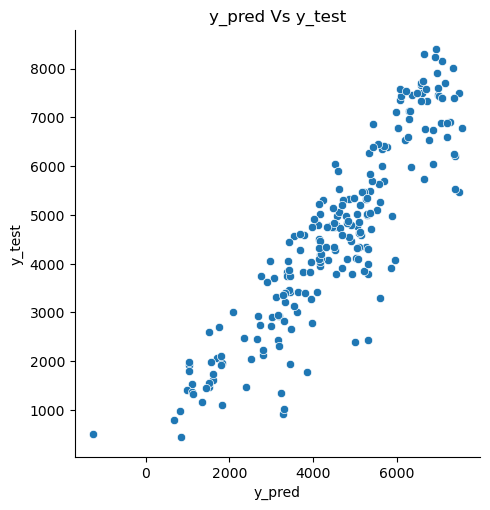

In [116]:
sns.relplot(x=y_pred,y=y_test,kind='scatter')
plt.title('y_pred Vs y_test')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [117]:
abs(pd.Series(lr.coef_,X_train.columns)).sort_values()

March            378.140564
winter           406.568711
September        590.942130
weathersit_2     655.625120
spring          1099.341692
windspeed       1237.604076
yr              2048.404459
weathersit_3    2488.939657
temp            3572.059512
dtype: float64

In [118]:

coef_vec = [[coef,cols ] for coef,cols in zip(lr.coef_,X_train.columns)] 


In [119]:
pd.Series([str(coef) + ' * ' + col + ' + ' for coef,col in coef_vec ]).sum().replace('+ -','-').replace('-','- ')

'2048.4044593888443 * yr - 1099.3416916196247 * spring + 406.5687110849967 * winter - 655.6251203984215 * weathersit_2 - 2488.939657422383 * weathersit_3 + 378.1405641050217 * March + 590.9421299229813 * September + 3572.0595119143572 * temp - 1237.6040757798473 * windspeed + '

- It can be inferred that temperature , weathersit_3 and yr have contributued the most towards prediction 

<Axes: >

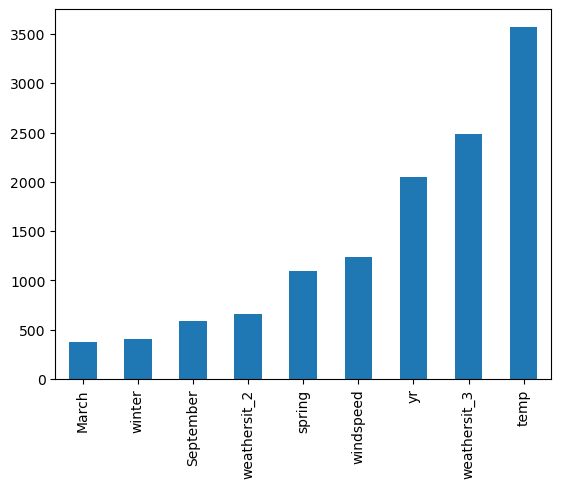

In [120]:
pd.Series(abs(lr.coef_),X_train.columns).sort_values().plot(kind='bar')

In [121]:
rfe_cols = pd.Series(abs(lr.coef_),X_train.columns).index

# Feature Selection II

# Backward Feature Selection

- Backward feature selection is done by repeatedly training the model by interatively changing feature set
- In each iteration(epoch) , each feature is removed and the r2-score of the model is calculated . Then at the end of the iteration(epoch) ,the feature with the least importance (i.e the model r2-score remains high even in the abensence of the feature) is removed . 
- Then the feature set that remains undergoes the same process 
- This happens until the noof features n(noof features to select)
- In this way the n most important features are selected

In [122]:
def train_model(X_train,y_train,X_test,y_test) : 
    estimator  = linear_model.LinearRegression()
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict(X_test)
    r2  =  r2_score(y_pred,y_test)
    return 1 - ((1-r2) * (X_train.shape[0]-1) / (X_train.shape[0] - 1 - X_train.shape[1]))
def backward_method(X_train,y_train,X_test,y_test,n) : 
    while(len(X_train.columns) > n) : 
        r2_scores  = []
        cols = X_train.columns
        for i in cols : 
            X_trainc = X_train.copy()
            X_testc = X_test.copy()
            X_trainc = X_train[X_trainc.columns[~X_trainc.columns.str.contains(i)]]
            X_testc = X_testc[X_testc.columns[~X_testc.columns.str.contains(i)]]
            r2_scores.append(train_model(X_trainc,y_train,X_testc,y_test))
        idx = r2_scores.index(max(r2_scores))
        X_train = X_train.drop(columns =cols[idx])
        X_test = X_test.drop(columns =cols[idx])
    return X_train,X_test
    

In [123]:
X_train,X_test,y_train,y_test = get_model_ready(df)
X_train,X_test = backward_method(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),16)

In [124]:
X_train.columns

Index(['yr', 'workingday', 'spring', 'summer', 'winter', 'weathersit_2',
       'weathersit_3', 'monday', 'tuesday', 'March', 'May', 'July', 'August',
       'November', 'December', 'temp'],
      dtype='object')

In [125]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     143.2
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.41e-173
Time:                        19:35:48   Log-Likelihood:                -4145.4
No. Observations:                 510   AIC:                             8325.
Df Residuals:                     493   BIC:                             8397.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1833.3562    278.220      6.590   

In [126]:
print(vif_method(X_train.copy()))

        Features   VIF
15          temp  6.88
1     workingday  3.48
4         winter  3.36
3         summer  3.00
0             yr  2.09
12        August  2.00
2         spring  1.95
11          July  1.90
13      November  1.76
10           May  1.60
5   weathersit_2  1.56
14      December  1.45
9          March  1.34
8        tuesday  1.32
7         monday  1.29
6   weathersit_3  1.08


In [127]:
X_train = X_train.drop(columns = 'tuesday')

In [128]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     152.5
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          2.43e-174
Time:                        19:35:48   Log-Likelihood:                -4146.2
No. Observations:                 510   AIC:                             8324.
Df Residuals:                     494   BIC:                             8392.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1836.3656    278.365      6.597   

In [129]:
print(vif_method(X_train.copy()))

        Features   VIF
14          temp  6.88
4         winter  3.36
1     workingday  3.14
3         summer  2.99
0             yr  2.09
11        August  2.00
2         spring  1.95
10          July  1.90
12      November  1.76
9            May  1.60
5   weathersit_2  1.56
13      December  1.44
8          March  1.34
7         monday  1.22
6   weathersit_3  1.07


In [130]:
X_train = X_train.drop(columns = 'May')

In [131]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     163.1
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          4.07e-175
Time:                        19:35:48   Log-Likelihood:                -4147.0
No. Observations:                 510   AIC:                             8324.
Df Residuals:                     495   BIC:                             8388.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1769.7426    273.406      6.473   

In [132]:
print(vif_method(X_train.copy()))

        Features   VIF
13          temp  6.81
4         winter  3.35
1     workingday  3.14
3         summer  2.53
0             yr  2.08
10        August  1.99
2         spring  1.95
9           July  1.89
11      November  1.76
5   weathersit_2  1.56
12      December  1.44
8          March  1.29
7         monday  1.22
6   weathersit_3  1.07


In [133]:
print(vif_method(X_train.copy()))

        Features   VIF
13          temp  6.81
4         winter  3.35
1     workingday  3.14
3         summer  2.53
0             yr  2.08
10        August  1.99
2         spring  1.95
9           July  1.89
11      November  1.76
5   weathersit_2  1.56
12      December  1.44
8          March  1.29
7         monday  1.22
6   weathersit_3  1.07


In [134]:
X_train = X_train.drop(columns = 'March')

In [135]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     174.9
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.09e-175
Time:                        19:35:48   Log-Likelihood:                -4148.3
No. Observations:                 510   AIC:                             8325.
Df Residuals:                     496   BIC:                             8384.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1760.0660    273.778      6.429   

In [136]:
print(vif_method(X_train.copy()))

        Features   VIF
12          temp  6.81
4         winter  3.35
1     workingday  3.14
3         summer  2.47
0             yr  2.08
9         August  1.99
8           July  1.89
10      November  1.76
2         spring  1.73
5   weathersit_2  1.56
11      December  1.43
7         monday  1.22
6   weathersit_3  1.07


In [137]:

X_train = X_train.drop(columns = 'August')

In [138]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     188.1
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          5.16e-176
Time:                        19:35:48   Log-Likelihood:                -4150.3
No. Observations:                 510   AIC:                             8327.
Df Residuals:                     497   BIC:                             8382.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1638.9420    267.420      6.129   

In [139]:
print(vif_method(X_train.copy()))

        Features   VIF
11          temp  4.48
1     workingday  3.13
4         winter  2.80
0             yr  2.07
3         summer  1.77
9       November  1.75
5   weathersit_2  1.55
2         spring  1.51
8           July  1.46
10      December  1.42
7         monday  1.22
6   weathersit_3  1.07


In [140]:
X_train_rfe = sm.add_constant(X_train)
lm = sm.OLS(y_train,X_train_rfe).fit()

In [141]:
y_pred_train = lm.predict(X_train_rfe)

 # The results of the model evaluations of RFE and Backward Feature Selection are almost the same 

In [142]:
(y_pred_train - y_train).mean()

1.213729596130696e-11

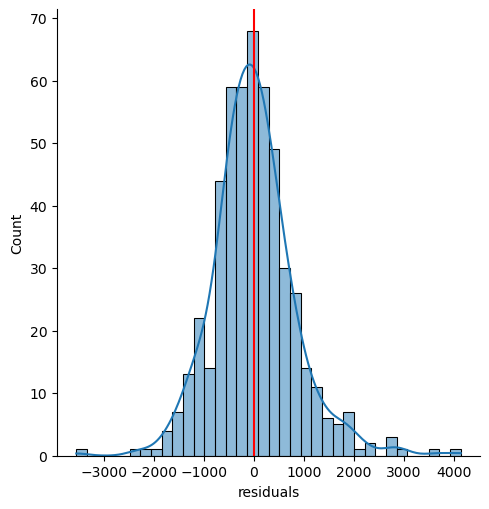

In [143]:
sns.displot(x=(y_pred_train - y_train),kde=True)
plt.xlabel('residuals')
plt.axvline(0,color='r')
plt.show()

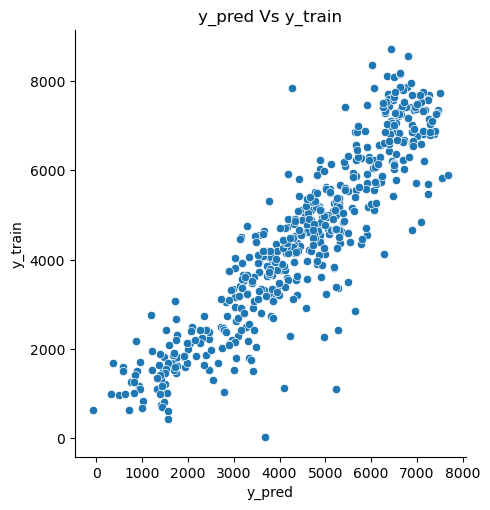

In [144]:
sns.relplot(x=y_pred_train,y=y_train,kind='scatter')
plt.title('y_pred Vs y_train')
plt.xlabel('y_pred')
plt.ylabel('y_train')
plt.show()

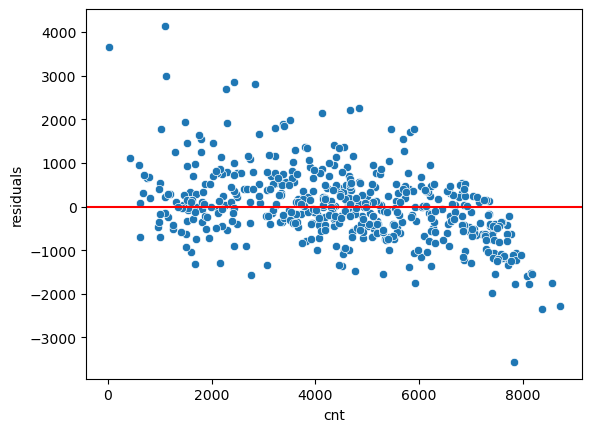

In [145]:
res  = (y_pred_train - y_train)
sns.scatterplot(x=y_train,y=res)
plt.ylabel('residuals')
plt.axhline(res.mean(),color='red')

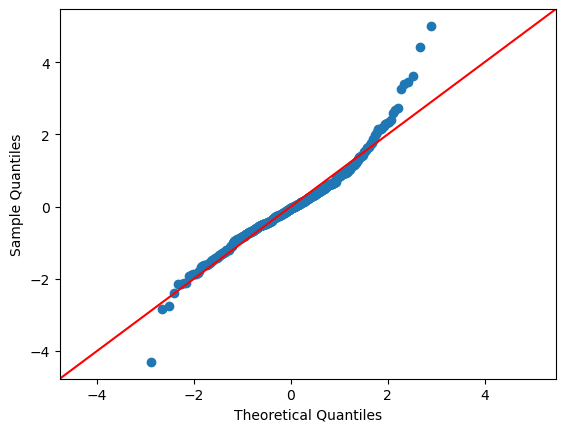

In [146]:
plot_qq(res)

In [147]:
X_test = X_test[X_train.columns]

In [148]:
X_test_lm = sm.add_constant(X_test)
y_pred = lm.predict(X_test_lm)
round(r2_score(y_pred,y_test),2)

0.78

In [149]:
lr = linear_model.LinearRegression()

In [150]:
lr.fit(X_train,y_train)

LinearRegression()

In [151]:
lr.coef_

array([ 2025.9027782 ,   242.60234263, -1015.0248454 ,    41.08301379,
         696.47875965,  -675.29095574, -2615.7091323 ,  -227.42649078,
        -630.73685763,  -499.3210609 ,  -309.00674582,  4055.6869061 ])

In [152]:
lr.intercept_

1638.9419719622056

In [153]:
X_test = X_test[X_train.columns]

In [154]:
y_pred = lr.predict(X_test)

# The r2-score for backward feature selection is 0.78

In [155]:
print(f"R2 Score of model - {round(r2_score(y_pred,y_test),2)}")

R2 Score of model - 0.78


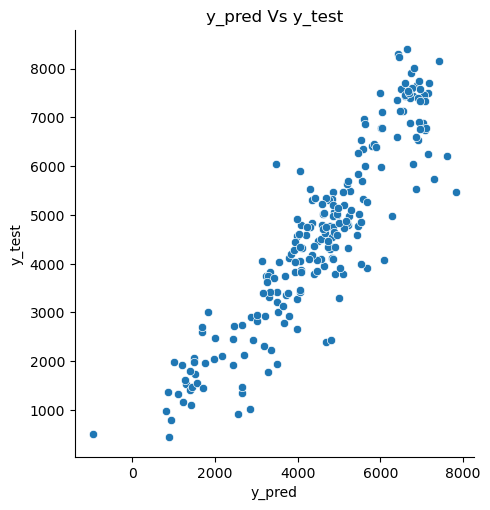

In [156]:
sns.relplot(x=y_pred,y=y_test,kind='scatter')
plt.title('y_pred Vs y_test')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [157]:
abs(pd.Series(lr.coef_,X_train.columns)).sort_values()

summer            41.083014
monday           227.426491
workingday       242.602343
December         309.006746
November         499.321061
July             630.736858
weathersit_2     675.290956
winter           696.478760
spring          1015.024845
yr              2025.902778
weathersit_3    2615.709132
temp            4055.686906
dtype: float64

In [158]:

coef_vec = [[coef,cols ] for coef,cols in zip(lr.coef_,X_train.columns)] 

In [159]:
pd.Series([str(coef) + ' * ' + col + ' + ' for coef,col in coef_vec ]).sum().replace('+ -','-').replace('-','- ')

'2025.9027782027 * yr + 242.60234262974154 * workingday - 1015.024845400838 * spring + 41.0830137860728 * summer + 696.4787596541881 * winter - 675.290955737469 * weathersit_2 - 2615.709132303261 * weathersit_3 - 227.4264907828067 * monday - 630.7368576300776 * July - 499.3210609004086 * November - 309.0067458223673 * December + 4055.6869060956997 * temp + '

<Axes: >

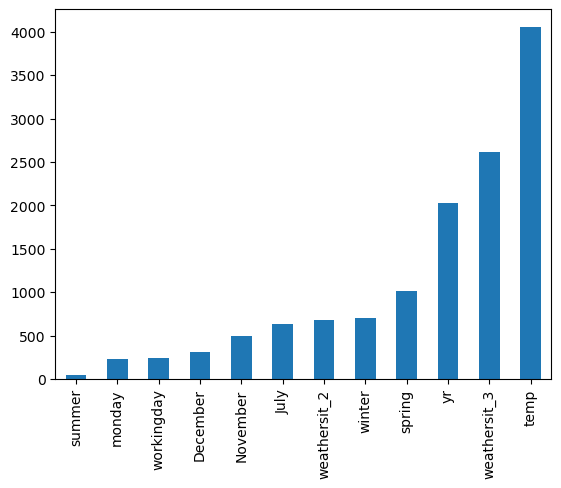

In [160]:
pd.Series(abs(lr.coef_),X_train.columns).sort_values().plot(kind='bar')

In [161]:
bcf_cols  = pd.Series(abs(lr.coef_),X_train.columns).index

# Intersection of features of rfe model and bcf model

In [162]:
np.intersect1d(rfe_cols,bcf_cols)

array(['spring', 'temp', 'weathersit_2', 'weathersit_3', 'winter', 'yr'],
      dtype=object)

- Note that the the top 3 features of both models are similar i.e temp , weathersit_3 and yr
- This gives more confidence in the results of the model
- It can also be observed that the residual analysis represents the same insights in both the feature selections
- This gives us more confidence that the model is going in the right direction

### This tells us the fact that temp , yr and weathersit_3 are the 3 most import features to the model

- Both models trained after using different feature selection techniques gave similar results in terms of model evaluation and test

# Trail 

 - It can be observed that removing year column lead to a very sharp drop in R-square

In [163]:
X_train,X_test,y_train,y_test = get_model_ready(df)

In [164]:
X_train,X_test = backward_method(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),16)

In [165]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     143.2
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.41e-173
Time:                        19:59:40   Log-Likelihood:                -4145.4
No. Observations:                 510   AIC:                             8325.
Df Residuals:                     493   BIC:                             8397.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1833.3562    278.220      6.590   

In [166]:
print(vif_method(X_train.copy()))

        Features   VIF
15          temp  6.88
1     workingday  3.48
4         winter  3.36
3         summer  3.00
0             yr  2.09
12        August  2.00
2         spring  1.95
11          July  1.90
13      November  1.76
10           May  1.60
5   weathersit_2  1.56
14      December  1.45
9          March  1.34
8        tuesday  1.32
7         monday  1.29
6   weathersit_3  1.08


In [167]:
X_train = X_train.drop(columns = 'yr')

In [168]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     41.56
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           1.34e-77
Time:                        20:00:03   Log-Likelihood:                -4378.7
No. Observations:                 510   AIC:                             8789.
Df Residuals:                     494   BIC:                             8857.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2056.5397    439.012      4.684   

In [169]:
X_train,X_test,y_train,y_test = get_model_ready(df)

In [170]:
X_train,X_test = backward_method(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),16)

In [171]:
X_train = X_train.drop(columns = 'temp')

In [172]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     108.5
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.71e-145
Time:                        20:02:02   Log-Likelihood:                -4215.2
No. Observations:                 510   AIC:                             8462.
Df Residuals:                     494   BIC:                             8530.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4806.8081    163.975     29.314   

In [173]:
X_train,X_test,y_train,y_test = get_model_ready(df)
X_train,X_test = backward_method(X_train.copy(),y_train.copy(),X_test.copy(),y_test.copy(),16)

In [175]:
X_train = X_train.drop(columns = 'weathersit_3')

In [176]:
print(stats_model_training(X_train.copy(),y_train.copy()))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          5.80e-148
Time:                        20:03:05   Log-Likelihood:                -4209.3
No. Observations:                 510   AIC:                             8451.
Df Residuals:                     494   BIC:                             8518.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1513.5978    313.568      4.827   